In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.formula.api as smf
import geopandas as gpd

# Target: measure the relationship between the change of housing rent price and entropy index of income_level groups

# DataFrames:
- df_PUMA: the PUMA list, incuding the code, community districts and the neighborhoods' names

- df: cleaned dataset
- df_all: all origin variables, combining dataset and PUMA information


- df_census_entropy: entropy index for 2089 census tracts
- df_puma_entropy: entropy index for 55 PUMAs



all useful variables except entropy index, including rent, income, rent growth, income growth, rent-income-ratio:
- df2: , at census tract level
- df_puma_median, at puma level, the median value of the census tracts in each PUMA


**all useful variables for analysis**, above + entropy index + entropy index change:
- **df_census_analysis** 
- **df_puma_analysis**


entropy and rent, **for regression**:
- **df_census_entropy_rent**
- **df_puma_entropy_rent**








# 1.Data cleaning

# 1.1 clean dataset
This dataset is exported from Geolytics: Neighborhood Change Database (NACD)
(http://demographics.geolytics.com/ncdb2010/default.aspx)


### the dataset has been uploaded on:
 https://github.com/picniclin/NYC_yl5240/blob/master/geolytics_NYC_census_1990-2010.csv
 
or
https://drive.google.com/a/nyu.edu/file/d/0B2HY61hRpF-jV21KSTVsbi1wS3M/view?usp=sharing

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/picniclin/NYC_yl5240/master/geolytics_NYC_census_1990-2010.csv')

In [3]:
df.shape

(2168, 146)

In [4]:
df.head()

,AREAKEY,STATE,STUSAB,INTPTLAT,INTPTLON,TCH_90_10,TCH_00_10,ZCTA5,TRCTPOP9,POVRAT9N,...,THY01001A,THY01251A,THY01501A,THY02001A,THY0M201A,MDHHY1A,MDVALHS1A,MCSMORT1A,MCSNMOR1A,MDGRENT1A
0,36005000100,36,NY,40.793492,-73.883532,0,0,11370.0,14303,0,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473.0,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473.0,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473.0,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454.0,1575,797,...,14,19,21,0,0,25093,0,0,539,870


In [5]:
# check the columns names
# list(df.columns)

## make the column names readable

In [6]:
df.columns

Index([u'AREAKEY', u'STATE', u'STUSAB', u'INTPTLAT', u'INTPTLON', u'TCH_90_10',
       u'TCH_00_10', u'ZCTA5', u'TRCTPOP9', u'POVRAT9N',
       ...
       u'THY01001A', u'THY01251A', u'THY01501A', u'THY02001A', u'THY0M201A',
       u'MDHHY1A', u'MDVALHS1A', u'MCSMORT1A', u'MCSNMOR1A', u'MDGRENT1A'],
      dtype='object', length=146)

In [7]:
cols = df.columns.str.replace('TRCTPOP', 'pop')\
            .str.replace('MDFAMY','median_inc_fam_')\
            .str.replace('FAVINC', 'ave_inc_fam_')\
            .str.replace('MDHHY', 'median_inc_hh_')\
            .str.replace('AVHHIN', 'ave_inc_hh_')\
            .str.replace('FALTY', 'fam_inc_')\
            .str.replace('FALT', 'fam_inc_')\
            .str.replace('MXB', 'max_')\
            .str.replace('FAY0', 'fam_inc_')\
            .str.replace('fam_inc_M', 'fam_inc_max_')\
            .str.replace('THY0', 'hh_inc_' )\
            .str.replace('hh_inc_M', 'hh_inc_max_')\
            .str.replace('MDVALHS','median_house_value_')\
            .str.replace('MDGRENT', 'median_rent_' )\
            .str.replace('MCSMORT', 'owner_cost_mo_' )\
            .str.replace('MCSNMOR', 'owner_cost_no_mo_' )\
            .str.replace('OCCHU', 'occ_')\
            .str.replace('VACHU', 'vacant_')\
            .str.replace('RNTOCC','renter_occ_')\
            .str.replace('OWNOCC', 'owner_occ_')\
            .str.replace('SPRNTOC', 'spec_renter_occ_')\
            .str.replace('SPOWNOC', 'spec_owner_occ_')\
            .str.replace('PRSOCU', 'person_occ_')\
            .str.replace('PRSOWNU', 'person_owner_occ_')\
            .str.replace('PRSRNTU', 'person_renter_occ_')\
            .str.replace('POVRAT','poverty')\
            .str.replace('1A', '1')\
            .str.replace('9A', '9')\
            
cols

Index([u'AREAKEY', u'STATE', u'STUSAB', u'INTPTLAT', u'INTPTLON', u'TCH_90_10',
       u'TCH_00_10', u'ZCTA5', u'pop9', u'poverty9N',
       ...
       u'hh_inc_1001', u'hh_inc_1251', u'hh_inc_1501', u'hh_inc_2001',
       u'hh_inc_max_201', u'median_inc_hh_1', u'median_house_value_1',
       u'owner_cost_mo_1', u'owner_cost_no_mo_1', u'median_rent_1'],
      dtype='object', length=146)

In [8]:
df.columns = cols

In [9]:
df.head()

,AREAKEY,STATE,STUSAB,INTPTLAT,INTPTLON,TCH_90_10,TCH_00_10,ZCTA5,pop9,poverty9N,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
0,36005000100,36,NY,40.793492,-73.883532,0,0,11370.0,14303,0,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473.0,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473.0,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473.0,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454.0,1575,797,...,14,19,21,0,0,25093,0,0,539,870


In [10]:
df.columns = cols

df.rename(columns = {'AREAKEY' : 'census_tract',
                     'STATE':'state','STUSAB':'abb.',
                     'TCH_90_10':'tract_change_90', 'TCH_00_10':'tract_change_00',
                    'INTPTLAT':'lat', 'INTPTLON':'lon'}, inplace = True)
df.columns

Index([u'census_tract', u'state', u'abb.', u'lat', u'lon', u'tract_change_90',
       u'tract_change_00', u'ZCTA5', u'pop9', u'poverty9N',
       ...
       u'hh_inc_1001', u'hh_inc_1251', u'hh_inc_1501', u'hh_inc_2001',
       u'hh_inc_max_201', u'median_inc_hh_1', u'median_house_value_1',
       u'owner_cost_mo_1', u'owner_cost_no_mo_1', u'median_rent_1'],
      dtype='object', length=146)

In [11]:
df = df.dropna()
df.ZCTA5 = df.ZCTA5.astype('int')
df.shape

(2157, 146)

In [12]:
## delete the observation, i.e. census tract, with 0 median rent or 0 median families income
df = df[~((df.median_rent_0 == 0)| (df.median_rent_9 == 0)|(df.median_rent_1 == 0)|\
         (df.median_inc_fam_9 == 0)| (df.median_inc_fam_9 == 0)|(df.median_inc_fam_1 == 0))]
## drop the redundant columns
df.drop(['state', 'abb.','tract_change_90','tract_change_00'], axis = 1, inplace = True)
df.head()

,census_tract,lat,lon,ZCTA5,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
1,36005000200,40.804573,-73.856859,10473,2907,411,0.142067,45267.28710,38711,29,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,40.808915,-73.850488,10473,2260,225,0.100089,43694.20068,40484,19,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,40.818848,-73.858076,10473,5254,893,0.179245,30042.84776,24732,142,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,40.800999,-73.909373,10454,1575,797,0.506032,23377.47813,24823,50,...,14,19,21,0,0,25093,0,0,539,870
5,36005002000,40.817580,-73.866096,10473,9110,3423,0.375741,25062.06250,18762,284,...,180,161,0,45,12,24939,398100,2185,715,455


In [13]:
df.shape

(2089, 142)

## 1.2 find the PUMA, NAT information for each census tract

### the CensusTract/NTA/PUMA Equivalencies table could be found on this [link](https://www1.nyc.gov/site/planning/data-maps/nyc-population/geographic-reference.page)
 the downloaded linkage is https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/nyc2010census_tabulation_equiv.xlsx
 
This xlsx includes two tables. Split it into two csv by excel.

And we extract the neighborhoods' names of each PUMA from the xlsx table from NYC DOP's ACS table:http://www1.nyc.gov/site/planning/data-maps/nyc-population/american-community-survey.page

### The three csv files have been uploaded on:
https://github.com/picniclin/NYC_yl5240
- 2010CensusTract_PUMA_NTA.csv
- 2010PUMA_NTA.csv
- PUMA_neighborhoods.csv



In [14]:
df_conv1 = pd.read_csv('https://raw.githubusercontent.com/picniclin/NYC_yl5240/master/2010CensusTract_PUMA_NTA.csv')
df_conv2 = pd.read_csv('https://raw.githubusercontent.com/picniclin/NYC_yl5240/master/2010PUMA_NTA.csv')
df_conv3 = pd.read_csv('https://raw.githubusercontent.com/picniclin/NYC_yl5240/master/PUMA_neighborhoods.csv')

In [15]:
## df_conv1 is the conversion table between census tract and PUMA/NTA
df_conv1.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens


In [16]:
## df_conv2 is the conversion table between PUMA and NTA
df_conv2.head()

,Borough,PUMA Code,PUMA_CommunityDistrict,NTA _Code,NTA_Name
0,Bronx,3701,BX Community District 8,BX22,North Riverdale-Fieldston-Riverdale
1,Bronx,3701,BX Community District 8,BX28,Van Cortlandt Village
2,Bronx,3701,BX Community District 8,BX29,Spuyten Duyvil-Kingsbridge
3,Bronx,3702,BX Community District 12,BX03,Eastchester-Edenwald-Baychester
4,Bronx,3702,BX Community District 12,BX44,Williamsbridge-Olinville


In [17]:
## df_conv3 is the neighborhoods'names for each PUMA
df_conv3.head()

,PUMA_CommunityDistrict,PUMA_neighborhoods
0,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA"
1,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA"
2,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA"
3,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA"
4,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA"


In [18]:
len(df_conv1), len(df_conv2), len(df_conv3)

(2168, 219, 55)

In [19]:
df_conv2.rename(columns = {'PUMA_CommunityDistrict \r':'PUMA_CommunityDistrict'}, inplace=True)

In [20]:
def abb_rep(x):
    if x.startswith('BX'):
        x = x.replace('BX','Bronx')
    if x.startswith('BK'):
        x = x.replace('BK','Brooklyn')
    if x.startswith('MN'):
        x = x.replace('MN','Manhattan')
    if x.startswith('QN'):
        x = x.replace('QN','Queens')
    if x.startswith('SI'):
        x = x.replace('SI','Staten Island')
    return x
        
df_conv2.PUMA_CommunityDistrict = df_conv2.PUMA_CommunityDistrict.apply(lambda x:abb_rep(x))

In [21]:
df_conv2.head()

,Borough,PUMA Code,PUMA_CommunityDistrict,NTA _Code,NTA_Name
0,Bronx,3701,Bronx Community District 8,BX22,North Riverdale-Fieldston-Riverdale
1,Bronx,3701,Bronx Community District 8,BX28,Van Cortlandt Village
2,Bronx,3701,Bronx Community District 8,BX29,Spuyten Duyvil-Kingsbridge
3,Bronx,3702,Bronx Community District 12,BX03,Eastchester-Edenwald-Baychester
4,Bronx,3702,Bronx Community District 12,BX44,Williamsbridge-Olinville


In [22]:
df_conv2_ = df_conv2.iloc[:,1:3].drop_duplicates().reset_index(drop = True)
df_conv2_.PUMA_CommunityDistrict = df_conv2_.PUMA_CommunityDistrict.\
                str.replace('Community Districts', 'Community District')


## the PUMA list: 55 PUMAs

In [23]:
## In df_conv2_, we could extract the PUMA list, including PUMA code and PUMA_CommunityDistrict
## and combine it with df_conve
df_PUMA = df_conv2_.merge(df_conv3, on = 'PUMA_CommunityDistrict')
df_PUMA

,PUMA Code,PUMA_CommunityDistrict,PUMA_neighborhoods
0,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA"
1,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA"
2,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA"
3,3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA"
4,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA"
5,3706,Bronx Community District 7,"Bedford Park, Fordham North & Norwood PUMA"
6,3707,Bronx Community District 5,"Morris Heights, Fordham South & Mount Hope PUMA"
7,3708,Bronx Community District 4,"Concourse, Highbridge & Mount Eden PUMA"
8,3709,Bronx Community District 9,"Castle Hill, Clason Point & Parkchester PUMA"
9,3710,Bronx Community District 1 & 2,"Hunts Point, Longwood & Melrose PUMA"


In [24]:
df_conv4 = pd.DataFrame([['Bronx', '36005'],['Brooklyn','36047'],['Manhattan','36061'], 
              ['Queens','36081'], ['Staten Island', '36085']], columns=['Borough','BroCode'])
df_conv4

,Borough,BroCode
0,Bronx,36005
1,Brooklyn,36047
2,Manhattan,36061
3,Queens,36081
4,Staten Island,36085


In [25]:
df_conv2.rename(columns = {'PUMA \rCode':'PUMA',  'NTA _Code': 'NTA_Code'}, inplace=True)

In [26]:
df_tract = df_conv1.merge(df_conv2.rename(columns={'PUMA Code':'PUMA'}), 
               on = ['NTA_Code', 'NTA_Name', 'Borough', 'PUMA']).merge(df_conv4, on = 'Borough')

df_tract.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name,PUMA_CommunityDistrict,BroCode
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005


In [27]:
df_tract['census_tract']  = (df_tract.BroCode +\
                        df_tract['2010CensusTract'].apply(lambda x : str(x).zfill(6))).astype(int)

### the census tract list: 2167 census tracts in NYC 2010

In [28]:
df_tract.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name,PUMA_CommunityDistrict,BroCode,census_tract
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005,36005031000
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005,36005031200
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005,36005031400
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005,36005031600
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens,Bronx Community District 11,36005,36005031800


In [29]:
df_tract = df_tract.iloc[:,[0,-1,2,-3,3,4]]
df_tract.head()

,Borough,census_tract,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,Bronx,36005031000,3704,Bronx Community District 11,BX31,Allerton-Pelham Gardens
1,Bronx,36005031200,3704,Bronx Community District 11,BX31,Allerton-Pelham Gardens
2,Bronx,36005031400,3704,Bronx Community District 11,BX31,Allerton-Pelham Gardens
3,Bronx,36005031600,3704,Bronx Community District 11,BX31,Allerton-Pelham Gardens
4,Bronx,36005031800,3704,Bronx Community District 11,BX31,Allerton-Pelham Gardens


In [30]:
df_tract.shape

(2167, 6)

In [31]:
# check does the conversion table contain all the census tract in dataset df
len(set(df['census_tract']) - set(df_tract['census_tract'])), \
len(set(df_tract['census_tract']) - set(df['census_tract']) ), \
len(set(df['census_tract']))

(0, 78, 2089)

#### Yes, the conversion table contain all the census tract in dataset df.

## 1.3 conbine the conversion table into dataset, to add the PUMA and NTA information

In [32]:
df_all = df.merge(df_tract, on = 'census_tract')

df_all.head()

,census_tract,lat,lon,ZCTA5,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name
0,36005000200,40.804573,-73.856859,10473,2907,411,0.142067,45267.28710,38711,29,...,59826,392500,2661,650,1273,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
1,36005000400,40.808915,-73.850488,10473,2260,225,0.100089,43694.20068,40484,19,...,71968,393700,2206,679,1330,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
2,36005001600,40.818848,-73.858076,10473,5254,893,0.179245,30042.84776,24732,142,...,30355,378100,2500,649,823,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park
3,36005001900,40.800999,-73.909373,10454,1575,797,0.506032,23377.47813,24823,50,...,25093,0,0,539,870,Bronx,3710,Bronx Community Districts 1 & 2,BX39,Mott Haven-Port Morris
4,36005002000,40.817580,-73.866096,10473,9110,3423,0.375741,25062.06250,18762,284,...,24939,398100,2185,715,455,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park


## df_all is a new whole dataset for further clean and analysis

In [33]:
# change the colomn location of df_cov's colomns
df_all = pd.concat([df_all.iloc[:,[0]], df_all.iloc[:,-5:], df_all.iloc[:,1:-5]], axis = 1)
df_all.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,pop9,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
0,36005000200,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,2907,...,152,203,48,68,11,59826,392500,2661,650,1273
1,36005000400,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,2260,...,255,97,161,96,73,71968,393700,2206,679,1330
2,36005001600,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,5254,...,171,20,38,20,0,30355,378100,2500,649,823
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,1575,...,14,19,21,0,0,25093,0,0,539,870
4,36005002000,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,9110,...,180,161,0,45,12,24939,398100,2185,715,455


In [34]:
df_all.shape, df.shape

((2089, 147), (2089, 142))

### We have 2089 census tracts for analysis.

# 2. split the dataset into several sub-tables

## 2.1 Geographies data table
according to http://guides.newman.baruch.cuny.edu/nyc_data/nbhoods, New York City neighborhood census data could use Public Use Microdata Areas (PUMAs).


In [35]:
# the sub-table of census tract information, including census tract id, latitude, longitude, and ZCTA.
# df_dataset_tract is part of df_tract , accrdance with the observations of dataset
# also three more variables than df_tract: lat, lon, ZCTA5 
df_dataset_tract = df_all.iloc[:, :9]
df_dataset_tract.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5
0,36005000200,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473
1,36005000400,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473
2,36005001600,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454
4,36005002000,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473


In [36]:
df_dataset_tract.shape

(2089, 9)

## 2.2 Tables for different years

In [37]:
df_1990 = pd.concat([df_all.iloc[:,0:4], df_all.iloc[:, 9:43]],axis =1)
df_2000 = pd.concat([df_all.iloc[:,0:4], df_all.iloc[:, 43:95]],axis =1)
df_2010 = pd.concat([df_all.iloc[:,:4], df_all.iloc[:, 95:]],axis =1)
df_1990.shape, df_2000.shape, df_2010.shape

((2089, 38), (2089, 56), (2089, 56))

In [38]:
df_1990.head(2)

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,pop9,poverty9N,poverty9,ave_inc_fam_9,median_inc_fam_9,fam_inc_109,...,owner_occ_9,spec_renter_occ_9,spec_owner_occ_9,person_occ_9,person_owner_occ_9,person_renter_occ_9,median_house_value_9,owner_cost_mo_9,owner_cost_no_mo_9,median_rent_9
0,36005000200,Bronx,3709,Bronx Community District 9,2907,411,0.142067,45267.28710,38711,29,...,587,379,365,2901,1845,1055,136500,1006,204,742
1,36005000400,Bronx,3709,Bronx Community District 9,2260,225,0.100089,43694.20068,40484,19,...,507,188,359,2254,1662,593,163234,1066,301,535


In [39]:
df_2000.head(2)

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,pop0,poverty0N,poverty0,ave_inc_fam_0,median_inc_fam_0,fam_inc_100,...,owner_occ_0,spec_renter_occ_0,spec_owner_occ_0,person_occ_0,person_owner_occ_0,person_renter_occ_0,median_house_value_0,owner_cost_mo_0,owner_cost_no_mo_0,median_rent_0
0,36005000200,Bronx,3709,Bronx Community District 9,3505,703,0.202477,50763.54348,50817,137,...,654,421,436,3495,2508,987,147500,1454,424,730
1,36005000400,Bronx,3709,Bronx Community District 9,3354,437,0.131508,48306.41829,41019,75,...,618,486,382,3342,2243,1099,157610,1562,422,643


In [40]:
df_2010.head(2)

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,pop1,occ_1,vacant_1,renter_occ_1,owner_occ_1,person_occ_1,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
0,36005000200,Bronx,3709,Bronx Community District 9,4334,1351,98,635,716,4329,...,152,203,48,68,11,59826,392500,2661,650,1273
1,36005000400,Bronx,3709,Bronx Community District 9,5503,1786,117,615,1171,5491,...,255,97,161,96,73,71968,393700,2206,679,1330


## 2.3 Income Tables

In [41]:
# the sub-table of median/avlerage families/households income
df_income = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') |\
                                (df_all.columns == 'Borough')|\
                                (df_all.columns == 'PUMA')|\
                                (df_all.columns == 'PUMA_CommunityDistrict')|\
                              (df_all.columns.str.startswith('median_inc_')) |\
                              (df_all.columns.str.startswith('ave_inc_'))]]
df_income.head()  

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
0,36005000200,Bronx,3709,Bronx Community District 9,45267.28710,38711,41034.78595,31632,50763.54348,50817,48547.32784,42539,67363.981,58368,66324.981,59826
1,36005000400,Bronx,3709,Bronx Community District 9,43694.20068,40484,41850.02374,36506,48306.41829,41019,45697.79035,39111,86056.373,73148,82305.160,71968
2,36005001600,Bronx,3709,Bronx Community District 9,30042.84776,24732,27803.12012,22739,36442.53563,30104,31610.56070,24552,43473.490,33555,38629.904,30355
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,23377.47813,24823,19303.58696,11215,31360.47431,23671,27995.65217,22772,35995.455,25489,33907.328,25093
4,36005002000,Bronx,3709,Bronx Community District 9,25062.06250,18762,22262.06940,14765,26817.80645,19694,24885.52589,14691,41842.527,30817,35687.455,24939


In [42]:
df_income.shape

(2089, 16)

In [43]:
df_income.describe()

,census_tract,PUMA,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.00000,2089.000000,2089.000000,2089.000000
mean,3.605455e+10,3959.150311,46240.797301,37689.401628,39246.703235,31309.411202,63576.869583,48874.026807,54229.582025,40628.821446,85376.28443,66207.958353,72345.813173,54703.689325
std,2.594637e+07,144.957985,28606.446820,18760.425689,19565.189172,13562.873547,45058.370638,28645.098401,29038.210224,18527.299709,62564.07724,39910.826453,40603.704702,25923.948148
min,3.600500e+10,3701.000000,0.000000,86.000000,0.000000,5360.000000,16376.090910,7354.000000,12747.077320,7863.000000,0.00000,8542.000000,0.000000,8694.000000
25%,3.604702e+10,3808.000000,30501.042240,24924.000000,27864.930300,21862.000000,40513.116200,30724.000000,37683.585970,27976.000000,52010.32700,40022.000000,48876.596000,36299.000000
50%,3.604712e+10,4009.000000,41866.927540,36218.000000,36208.754250,30417.000000,53041.525420,42590.000000,48376.129030,37936.000000,70564.74300,56726.000000,64120.604000,51127.000000
75%,3.608103e+10,4103.000000,53084.721130,46843.000000,46187.374640,39697.000000,69321.465430,58977.000000,62046.691640,50806.000000,93098.66200,80125.000000,82035.096000,68026.000000
max,3.608503e+10,4114.000000,327320.474100,150001.000000,248923.005700,147567.000000,450967.828700,200001.000000,337238.297900,174119.000000,636204.42600,250001.000000,464390.618000,232768.000000


### Since there is no household income in 1990, we prefer to choose family income data as income data

In [44]:
df_family_income = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') | \
                                (df_all.columns == 'Borough')|\
                                (df_all.columns == 'PUMA')|\
                                (df_all.columns == 'PUMA_CommunityDistrict')|\
                                       df_all.columns.str.startswith('fam_inc_')]]
df_family_income.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
0,36005000200,Bronx,3709,Bronx Community District 9,29,29,12,31,20,32,...,36,142,24,77,49,136,221,60,38,0
1,36005000400,Bronx,3709,Bronx Community District 9,19,17,11,34,1,50,...,41,60,53,174,79,206,79,145,116,46
2,36005001600,Bronx,3709,Bronx Community District 9,142,28,124,84,41,165,...,99,78,124,19,167,129,20,29,20,0
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,50,39,0,0,3,0,...,1,32,0,22,16,12,9,21,0,0
4,36005002000,Bronx,3709,Bronx Community District 9,284,201,107,60,74,131,...,124,62,138,119,63,103,161,0,45,12


In [45]:
# the tables of different groups of families income level
df_family_income_1990 = df_family_income.loc[:,
                        df_family_income.columns[(df_family_income.columns == 'census_tract') |\
                                (df_family_income.columns == 'Borough')|\
                                (df_family_income.columns == 'PUMA')|\
                                (df_family_income.columns == 'PUMA_CommunityDistrict')|\
                                                    df_family_income.columns.str.endswith('9')]]

df_family_income_2000 = df_family_income.loc[:,
                        df_family_income.columns[(df_family_income.columns == 'census_tract') |\
                                (df_family_income.columns == 'Borough')|\
                                (df_family_income.columns == 'PUMA')|\
                                (df_family_income.columns == 'PUMA_CommunityDistrict')|\
                                                    df_family_income.columns.str.endswith('0')]]

df_family_income_2010 = df_family_income.loc[:,
                        df_family_income.columns[(df_family_income.columns == 'census_tract') |\
                                (df_family_income.columns == 'Borough')|\
                                (df_family_income.columns == 'PUMA')|\
                                (df_family_income.columns == 'PUMA_CommunityDistrict')|\
                                                    df_family_income.columns.str.endswith('1')]]

 
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 18), (2089, 20), (2089, 20))

In [46]:
df_family_income_1990.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,fam_inc_1009,fam_inc_1259,fam_inc_1509,fam_inc_max_9
0,36005000200,Bronx,3709,Bronx Community District 9,29,29,12,31,20,32,31,84,75,59,68,35,18,2
1,36005000400,Bronx,3709,Bronx Community District 9,19,17,11,34,1,50,50,89,71,58,62,28,1,1
2,36005001600,Bronx,3709,Bronx Community District 9,142,28,124,84,41,165,39,161,69,70,45,11,0,0
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,50,39,0,0,3,0,0,67,26,10,0,0,0,0
4,36005002000,Bronx,3709,Bronx Community District 9,284,201,107,60,74,131,95,203,158,40,84,8,0,13


## 2.4 Housing tables, including data of house value and rent

In [47]:
# the sub-table of housing price and rent
df_house = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') |\
                                (df_all.columns == 'Borough')|\
                                (df_all.columns == 'PUMA')|\
                                (df_all.columns == 'PUMA_CommunityDistrict')|\
                              (df_all.columns.str.startswith('median_rent_')) |\
                              (df_all.columns.str.startswith('median_house_'))]]
df_house

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
0,36005000200,Bronx,3709,Bronx Community District 9,136500,742,147500,730,392500,1273
1,36005000400,Bronx,3709,Bronx Community District 9,163234,535,157610,643,393700,1330
2,36005001600,Bronx,3709,Bronx Community District 9,156800,466,177000,558,378100,823
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,48868,422,145960,461,0,870
4,36005002000,Bronx,3709,Bronx Community District 9,185400,298,177600,266,398100,455
5,36005002300,Bronx,3710,Bronx Community Districts 1 & 2,0,186,0,229,0,359
6,36005002500,Bronx,3710,Bronx Community Districts 1 & 2,87500,276,99100,340,381300,570
7,36005002701,Bronx,3710,Bronx Community Districts 1 & 2,0,192,0,264,0,539
8,36005002702,Bronx,3710,Bronx Community Districts 1 & 2,0,284,162500,332,350000,592
9,36005002800,Bronx,3709,Bronx Community District 9,151600,423,155300,586,262000,849


In [48]:
df_house.shape

(2089, 10)

In [49]:
df_house.describe()

,census_tract,PUMA,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2.089000e+03,2089.000000,2.089000e+03,2089.000000
mean,3.605455e+10,3959.150311,170909.090953,544.198181,2.233565e+05,753.071326,5.070657e+05,1151.020105
std,2.594637e+07,144.957985,110359.984751,150.069074,1.826276e+05,231.835763,2.214706e+05,331.293631
min,3.600500e+10,3701.000000,0.000000,140.000000,0.000000e+00,175.000000,0.000000e+00,231.000000
25%,3.604702e+10,3808.000000,118204.000000,453.000000,1.604000e+05,644.000000,3.981000e+05,964.000000
50%,3.604712e+10,4009.000000,171500.000000,531.000000,1.964000e+05,740.000000,4.941000e+05,1120.000000
75%,3.608103e+10,4103.000000,218689.000000,629.000000,2.508000e+05,834.000000,6.275000e+05,1308.000000
max,3.608503e+10,4114.000000,500001.000000,1001.000000,1.000001e+06,2001.000000,1.000001e+06,2001.000000


# 3. Analysis based on census tract

## 1）create the table for relationship analysis

The variables we need are median family income, median rent, families with different income level

## Look at a whole view of income and rent
To compare the 1990 data, we choose the family income, not household income.

In [50]:
df2 = df_all.loc[:,df_all.columns[(df_all.columns == 'census_tract') |\
                                (df_all.columns == 'Borough')|\
                                (df_all.columns == 'PUMA')|\
                                (df_all.columns == 'PUMA_CommunityDistrict')|\
                          (df_all.columns.str.startswith('median_inc_fam'))|\
                          (df_all.columns.str.startswith('median_rent')) ]]

In [51]:
df2.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1
0,36005000200,Bronx,3709,Bronx Community District 9,38711,742,50817,730,58368,1273
1,36005000400,Bronx,3709,Bronx Community District 9,40484,535,41019,643,73148,1330
2,36005001600,Bronx,3709,Bronx Community District 9,24732,466,30104,558,33555,823
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,24823,422,23671,461,25489,870
4,36005002000,Bronx,3709,Bronx Community District 9,18762,298,19694,266,30817,455


In [52]:
df2['rent_income_ratio_9'] = df2['median_rent_9'] * 12/df2['median_inc_fam_9']
df2['rent_income_ratio_0'] = df2['median_rent_0'] * 12/df2['median_inc_fam_0']
df2['rent_income_ratio_1'] = df2['median_rent_1'] * 12/df2['median_inc_fam_1']
df2.shape

(2089, 13)

In [53]:
df2['rent_income_ratio_9'].describe()[5]

0.18370514654411541

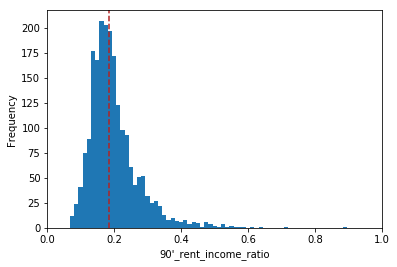

In [54]:
ax = df2.rent_income_ratio_9.plot(kind="hist", bins = 10000)
plt.axvline( x = df2['rent_income_ratio_9'].describe()[5], color = 'firebrick', linestyle = '--' )
ax.set_xlim(0,1)
ax.set_xlabel("90'_rent_income_ratio");

In [55]:
df2['rent_income_ratio_0'].describe()

count    2089.000000
mean        0.214373
std         0.074864
min         0.010500
25%         0.164954
50%         0.204193
75%         0.253730
max         1.194452
Name: rent_income_ratio_0, dtype: float64

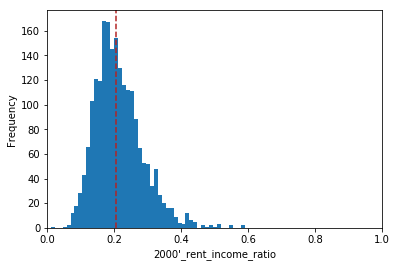

In [56]:
ax = df2.rent_income_ratio_0.plot(kind="hist", bins = 100)
plt.axvline( x = df2['rent_income_ratio_0'].describe()[5], color = 'firebrick', linestyle = '--' )
ax.set_xlim(0,1)
ax.set_xlabel("2000'_rent_income_ratio");

In [57]:
df2['rent_income_ratio_1'].describe()

count    2089.000000
mean        0.248931
std         0.100567
min         0.042308
25%         0.181756
50%         0.235058
75%         0.300615
max         1.298057
Name: rent_income_ratio_1, dtype: float64

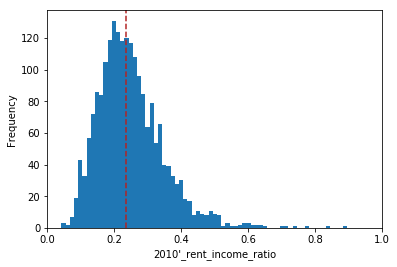

In [58]:
ax = df2.rent_income_ratio_1.plot(kind="hist", bins = 100)
plt.axvline( x = df2['rent_income_ratio_1'].describe()[5], color = 'firebrick', linestyle = '--' )
ax.set_xlim(0,1)
ax.set_xlabel("2010'_rent_income_ratio");

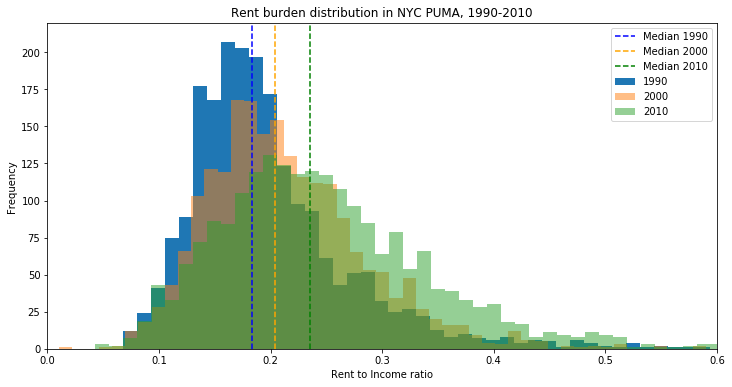

In [59]:
plt.figure(figsize=(12,6))
ax1 = df2.rent_income_ratio_9.plot(kind="hist", bins = 10000, label = '1990')
plt.axvline( x = df2['rent_income_ratio_9'].describe()[5], color = 'blue', linestyle = '--', label = 'Median 1990' )
ax1.set_xlim(0, 0.6)
ax1.set_ylim(0,220)
ax1.set_xlabel("1990'_rent_income_ratio");
ax1.set_title('Rent burden distribution in NYC PUMA, 1990-2010')

ax2 = df2.rent_income_ratio_0.plot(kind="hist", bins = 100 , alpha = 0.5, label = '2000' )
plt.axvline( x = df2['rent_income_ratio_0'].describe()[5], color = 'orange', linestyle = '--', label = 'Median 2000' )
ax2.set_xlim(0, 0.6)
ax2.set_xlabel("Rent to Income ratio");

ax3 = df2.rent_income_ratio_1.plot(kind="hist", bins = 100, alpha = 0.5, label = '2010' )
plt.axvline( x = df2['rent_income_ratio_1'].describe()[5], color = 'green', linestyle = '--', label = 'Median 2010' )
ax3.set_xlim(0, 0.6)
ax3.set_xlabel('Rent to Income ratio');
ax1.legend()
plt.show()

## to see how does the income and rent change between 1990-2010

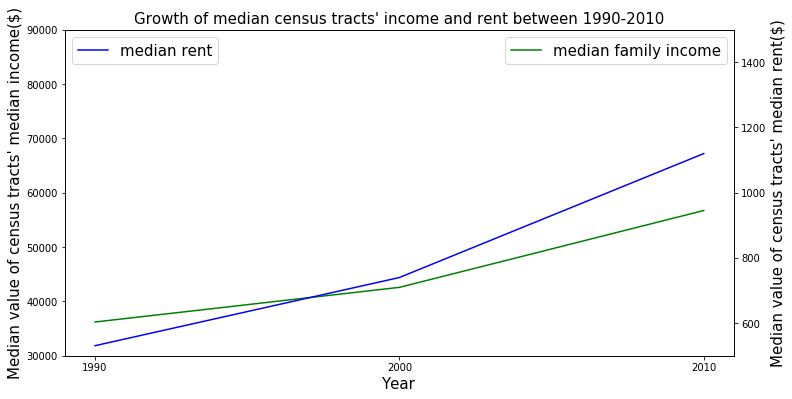

In [60]:
## select the median value of 2089 census tract
fig, ax1 = plt.subplots(figsize = (12, 6))
ax2 = ax1.twinx()
ax1.plot(np.arange(3), df2.median().loc[['median_inc_fam_9',
                                        'median_inc_fam_0',
                                        'median_inc_fam_1']], c = 'g', label = 'median family income')
ax2.plot(np.arange(3), df2.median().loc[['median_rent_9',
                                        'median_rent_0',
                                        'median_rent_1']], c = 'b', label = 'median rent')
ax1.legend(loc = 'upper right', fontsize = 15)
ax2.legend(loc = 'upper left', fontsize = 15)

ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel("Median value of census tracts' median income($)", fontsize = 15)
ax1.set_ylim((30000,90000))

ax2.set_ylabel("Median value of census tracts' median rent($)", fontsize = 15)
ax2.set_ylim((500, 1500))

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.title("Growth of median census tracts' income and rent between 1990-2010", fontsize = 15)

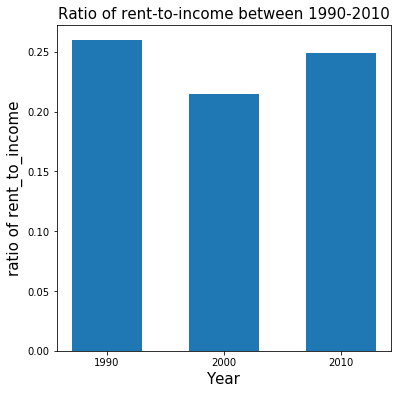

In [61]:
## see how does rent-to-income ratio change
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df2.mean().loc[['rent_income_ratio_9',
                                        'rent_income_ratio_0',
                                        'rent_income_ratio_1']], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('ratio of rent_to_income', fontsize = 15)
plt.title('Ratio of rent-to-income between 1990-2010', fontsize = 15)

## Calculate the change of rent between 1990-2000 and 2000-2010

In [62]:
df2['inc_growth_90_00'] = df2.median_inc_fam_0/df2.median_inc_fam_9 - 1
df2['inc_growth_00_10'] = df2.median_inc_fam_1/df2.median_inc_fam_0 - 1

df2['rent_growth_90_00'] = df2.median_rent_0/df2.median_rent_9 - 1
df2['rent_growth_00_10'] = df2.median_rent_1/df2.median_rent_0 - 1
df2.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
0,36005000200,Bronx,3709,Bronx Community District 9,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719,0.312728,0.148592,-0.016173,0.743836
1,36005000400,Bronx,3709,Bronx Community District 9,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188,0.013215,0.783271,0.201869,1.068429
2,36005001600,Bronx,3709,Bronx Community District 9,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323,0.217208,0.114636,0.197425,0.474910
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588,-0.046409,0.076803,0.092417,0.887202
4,36005002000,Bronx,3709,Bronx Community District 9,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175,0.049675,0.564791,-0.107383,0.710526


In [63]:
df2.describe()

,census_tract,PUMA,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,3.605455e+10,3959.150311,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931,1.017393,0.386582,0.394707,0.554580
std,2.594637e+07,144.957985,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567,32.109538,0.371344,0.243999,0.341645
min,3.600500e+10,3701.000000,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308,-0.463329,-0.789146,-0.825175,-0.673401
25%,3.604702e+10,3808.000000,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756,0.100910,0.155940,0.272441,0.412500
50%,3.604712e+10,4009.000000,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058,0.250178,0.336591,0.378641,0.525917
75%,3.608103e+10,4103.000000,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615,0.426565,0.545935,0.486239,0.655766
max,3.608503e+10,4114.000000,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057,1467.779070,3.714033,3.547727,10.434286


## df2 is the table containing the useful variables we need from dataset(not including entropy index, based on census tract)
- income
- rent
- rent-income-ratio
- income growth
- rent growth

## 2) Calculation of census tracts' entropy index 
entropy index of different income-level groups for each census tract from 1990 to 2010

entropy index fomular:
https://github.com/picniclin/NYC_yl5240/blob/master/entropy_index_fomular.png

In [64]:
# define entropy index 
def entropy_index(x):
    Q_sum = 0
    for i in x:
        if i == 0:
            Q = 0
        else:
            Q = (-1) * (i/(1.0 *sum(x))) * np.log(i/(1.0 * sum(x)))
        Q_sum += Q
    entropy_index = Q_sum/np.log(len(x))
    return entropy_index

In [65]:
# have a try
entropy_index(list(df_family_income_1990.iloc[0,5:]))

0.91644438056067445

In [66]:
df_family_income_1990.iloc[0,5:]

fam_inc_159      29
fam_inc_209      12
fam_inc_259      31
fam_inc_309      20
fam_inc_359      32
fam_inc_409      31
fam_inc_499      84
fam_inc_609      75
fam_inc_759      59
fam_inc_1009     68
fam_inc_1259     35
fam_inc_1509     18
fam_inc_max_9     2
Name: 0, dtype: object

In [67]:
# calculate the entropy index of 1990
for i in df_family_income_1990.index:
    df_family_income_1990.loc[i,'entropy_index_9'] = \
                    entropy_index(list(df_family_income_1990.loc[i,'fam_inc_109':'fam_inc_max_9']))

In [68]:
# calculate the entropy index of 2000 and 2010
for i in df_family_income_2000.index:
    df_family_income_2000.loc[i,'entropy_index_0'] = \
                    entropy_index(list(df_family_income_2000.loc[i,'fam_inc_100':'fam_inc_max_200']))

for i in df_family_income_2010.index:
    df_family_income_2010.loc[i,'entropy_index_1'] = \
                    entropy_index(list(df_family_income_2010.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [69]:
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 19), (2089, 21), (2089, 21))

In [70]:
df_family_income_1990.iloc[0,5:]

fam_inc_159              29
fam_inc_209              12
fam_inc_259              31
fam_inc_309              20
fam_inc_359              32
fam_inc_409              31
fam_inc_499              84
fam_inc_609              75
fam_inc_759              59
fam_inc_1009             68
fam_inc_1259             35
fam_inc_1509             18
fam_inc_max_9             2
entropy_index_9    0.922469
Name: 0, dtype: object

## Table of Census tract entropy index! That's what we need! The milestone!

In [71]:
df_census_entropy = df_dataset_tract.merge(pd.concat([df_family_income_1990.iloc[:,[0,-1]],
                              df_family_income_2000.iloc[:,-1],
                              df_family_income_2010.iloc[:,-1]], axis = 1), on = 'census_tract')

df_census_entropy['entropy_index_change_90_00'] = \
                df_census_entropy.entropy_index_0/df_census_entropy.entropy_index_9 - 1
df_census_entropy['entropy_index_change_00_10'] = \
                df_census_entropy.entropy_index_1/df_census_entropy.entropy_index_0 - 1
df_census_entropy.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10
0,36005000200,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,0.922469,0.871427,0.894048,-0.055331,0.025959
1,36005000400,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,0.863543,0.914607,0.898725,0.059133,-0.017365
2,36005001600,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,0.863912,0.902281,0.894488,0.044414,-0.008637
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,0.577145,0.825729,0.842364,0.430712,0.020146
4,36005002000,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,0.875156,0.795292,0.918302,-0.091257,0.154674


In [72]:
df_census_entropy.shape

(2089, 14)

In [73]:
df_census_entropy.describe()

,census_tract,PUMA,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10
count,2.089000e+03,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2087.000000,2089.000000
mean,3.605455e+10,3959.150311,40.716006,-73.916184,10943.422212,0.834267,0.877410,0.836504,inf,inf
std,2.594637e+07,144.957985,0.084051,0.086625,504.410705,0.092665,0.073188,0.096659,NaN,NaN
min,3.600500e+10,3701.000000,40.499787,-74.243439,10001.000000,0.000000,0.000000,0.000000,-0.382509,-1.000000
25%,3.604702e+10,3808.000000,40.648978,-73.966858,10461.000000,0.810977,0.852997,0.803280,0.007870,-0.090980
50%,3.604712e+10,4009.000000,40.706143,-73.919612,11213.000000,0.854512,0.896265,0.860130,0.044257,-0.035758
75%,3.608103e+10,4103.000000,40.769100,-73.861590,11357.000000,0.884843,0.923491,0.899579,0.086262,0.009880
max,3.608503e+10,4114.000000,40.909668,-73.704608,11697.000000,0.962561,0.978050,0.979375,inf,inf


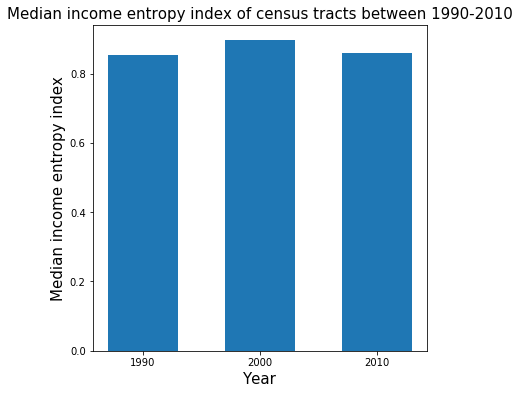

In [74]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_census_entropy.median()[-5:-2], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Median income entropy index of census tracts between 1990-2010', fontsize = 15)

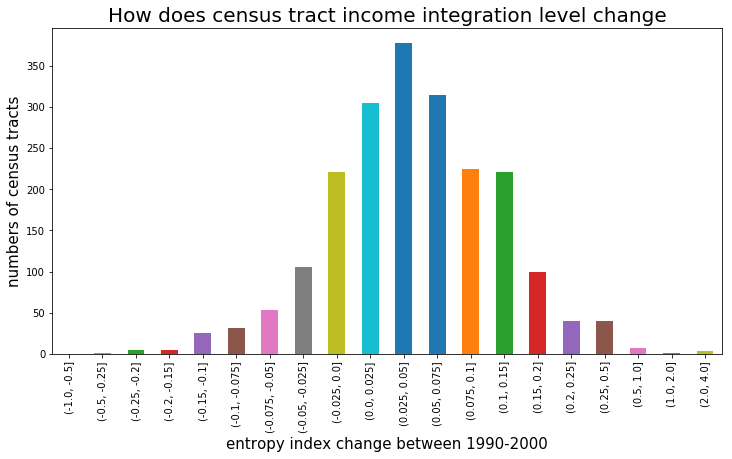

In [75]:
plt.figure(figsize = (12, 6))
cut = [-1,-0.5,-0.25,-0.2, -0.15,-0.1,-0.075, -0.05, -0.025, 0, 
       0.025,0.05,0.075, 0.1, 0.15, 0.2, 0.25,0.5,1,2,4]
df_census_entropy.iloc[:,0].groupby(pd.cut(df_census_entropy.entropy_index_change_90_00, 
          cut)).count().plot(kind = 'bar')
plt.xlabel('entropy index change between 1990-2000', fontsize = 15)
plt.ylabel('numbers of census tracts', fontsize = 15)
plt.title('How does census tract income integration level change', fontsize = 20)
plt.show()


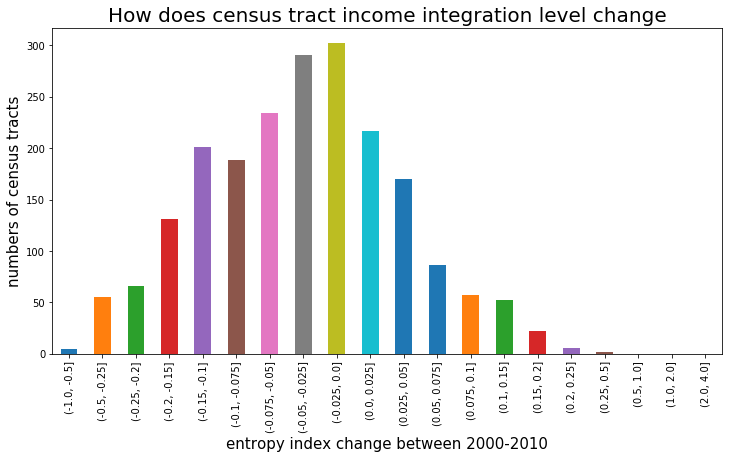

In [76]:
plt.figure(figsize = (12, 6))
df_census_entropy.iloc[:,0].groupby(pd.cut(df_census_entropy.entropy_index_change_00_10, 
          cut)).count().plot(kind = 'bar')
plt.xlabel('entropy index change between 2000-2010', fontsize = 15)
plt.ylabel('numbers of census tracts', fontsize = 15)
plt.title('How does census tract income integration level change', fontsize = 20)
plt.show()

## 3) Combine entropy index and rent growth


In [77]:
sum(np.array(df_census_entropy == 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 1, 0, 0])

In [78]:
## delete the observation with 0 entropy index
df_census_entropy = df_census_entropy[~((df_census_entropy.entropy_index_9 == 0)| (df_census_entropy.entropy_index_0 == 0)|\
                          (df_census_entropy.entropy_index_1 == 0))]

df_census_entropy.shape, sum(np.array(df_census_entropy == 0))

((2080, 14), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## This is the Table on Census tract level for entropy index, rent growth and entropy index growth

In [79]:
df_census_entropy_rent = df_census_entropy.merge(df2.loc[:,['census_tract',
                                    'median_rent_9','median_rent_0','median_rent_1',
                                    'rent_growth_90_00','rent_growth_00_10']], 
                                                  on = 'census_tract' )
    
   
df_census_entropy_rent.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,median_rent_9,median_rent_0,median_rent_1,rent_growth_90_00,rent_growth_00_10
0,36005000200,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,0.922469,0.871427,0.894048,-0.055331,0.025959,742,730,1273,-0.016173,0.743836
1,36005000400,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,0.863543,0.914607,0.898725,0.059133,-0.017365,535,643,1330,0.201869,1.068429
2,36005001600,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,0.863912,0.902281,0.894488,0.044414,-0.008637,466,558,823,0.197425,0.474910
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,0.577145,0.825729,0.842364,0.430712,0.020146,422,461,870,0.092417,0.887202
4,36005002000,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,0.875156,0.795292,0.918302,-0.091257,0.154674,298,266,455,-0.107383,0.710526


In [80]:
df_census_entropy_rent.shape

(2080, 19)

In [81]:
df_census_entropy_rent.describe()

,census_tract,PUMA,lat,lon,ZCTA5,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,median_rent_9,median_rent_0,median_rent_1,rent_growth_90_00,rent_growth_00_10
count,2.080000e+03,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,3.605454e+10,3959.710577,40.715837,-73.915934,10946.699519,0.837531,0.878937,0.837894,0.056854,-0.045796,543.339423,751.245673,1148.772596,0.393492,0.550774
std,2.597060e+07,144.859288,0.084136,0.086686,502.490844,0.076998,0.066597,0.093337,0.130683,0.093989,149.270985,227.074914,328.446693,0.235155,0.264145
min,3.600500e+10,3701.000000,40.499787,-74.243439,10001.000000,0.172632,0.362708,0.199940,-0.382509,-0.716018,140.000000,195.000000,231.000000,-0.375714,-0.673401
25%,3.604702e+10,3808.000000,40.648835,-73.966621,10461.000000,0.811590,0.854212,0.804635,0.007665,-0.090916,453.000000,644.000000,964.000000,0.272691,0.412871
50%,3.604712e+10,4009.000000,40.705775,-73.919253,11214.000000,0.854884,0.896428,0.860526,0.044176,-0.035732,531.000000,740.000000,1120.000000,0.378611,0.526301
75%,3.608103e+10,4103.000000,40.769151,-73.861136,11357.000000,0.885035,0.923663,0.899776,0.085437,0.009554,629.000000,833.000000,1305.250000,0.485551,0.655776
max,3.608503e+10,4114.000000,40.909668,-73.704608,11697.000000,0.962561,0.978050,0.979375,3.258258,0.296619,1001.000000,2001.000000,2001.000000,3.547727,3.600000


## the table with all variables we need

In [82]:
df_census_analysis = df_census_entropy.merge(df2, 
                                on = ['census_tract','Borough','PUMA', 'PUMA_CommunityDistrict'])
df_census_analysis.head()

,census_tract,Borough,PUMA,PUMA_CommunityDistrict,NTA_Code,NTA_Name,lat,lon,ZCTA5,entropy_index_9,...,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
0,36005000200,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.804573,-73.856859,10473,0.922469,...,730,58368,1273,0.230012,0.172383,0.261719,0.312728,0.148592,-0.016173,0.743836
1,36005000400,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.808915,-73.850488,10473,0.863543,...,643,73148,1330,0.158581,0.188108,0.218188,0.013215,0.783271,0.201869,1.068429
2,36005001600,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.818848,-73.858076,10473,0.863912,...,558,33555,823,0.226104,0.222429,0.294323,0.217208,0.114636,0.197425,0.474910
3,36005001900,Bronx,3710,Bronx Community Districts 1 & 2,BX39,Mott Haven-Port Morris,40.800999,-73.909373,10454,0.577145,...,461,25489,870,0.204004,0.233704,0.409588,-0.046409,0.076803,0.092417,0.887202
4,36005002000,Bronx,3709,Bronx Community District 9,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.817580,-73.866096,10473,0.875156,...,266,30817,455,0.190598,0.162080,0.177175,0.049675,0.564791,-0.107383,0.710526


In [83]:
df_census_analysis.shape

(2080, 27)

In [84]:
df_census_analysis.columns

Index([u'census_tract', u'Borough', u'PUMA', u'PUMA_CommunityDistrict',
       u'NTA_Code', u'NTA_Name', u'lat', u'lon', u'ZCTA5', u'entropy_index_9',
       u'entropy_index_0', u'entropy_index_1', u'entropy_index_change_90_00',
       u'entropy_index_change_00_10', u'median_inc_fam_9', u'median_rent_9',
       u'median_inc_fam_0', u'median_rent_0', u'median_inc_fam_1',
       u'median_rent_1', u'rent_income_ratio_9', u'rent_income_ratio_0',
       u'rent_income_ratio_1', u'inc_growth_90_00', u'inc_growth_00_10',
       u'rent_growth_90_00', u'rent_growth_00_10'],
      dtype='object')

## 4) OLS regression between rent growth and entropy index, on census tract level

In [85]:
lm1 = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_census_entropy_rent).fit()
lm2 = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_census_entropy_rent).fit()

In [86]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.51
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           0.000144
Time:                        14:07:44   Log-Likelihood:                 67.161
No. Observations:                2080   AIC:                            -130.3
Df Residuals:                    2078   BIC:                            -119.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6065      0.056     10.800      0.000       0.496       0.717
entropy_index_9    -0.2543      0.067     -3.809      0.000      -0.385      -0.123
==============================================================================
Omnibus:                     1262.560   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39327.293
Skew:                           2.323   Prob(JB):                         0.00
Kurtosis:                      23.789   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.395
Date:                Tue, 21 Nov 2017   Prob (F-statistic):             0.0655
Time:                        14:07:44   Log-Likelihood:                -180.18
No. Observations:                2080   AIC:                             364.4
Df Residuals:                    2078   BIC:                             375.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6916      0.077      9.025      0.000       0.541       0.842
entropy_index_0    -0.1602      0.087     -1.843      0.066      -0.331       0.010
==============================================================================
Omnibus:                      858.727   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13975.251
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                      15.335   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = -0.254 * Tract_Entropy_Index_90 + 0.606, R-squared = 0.007


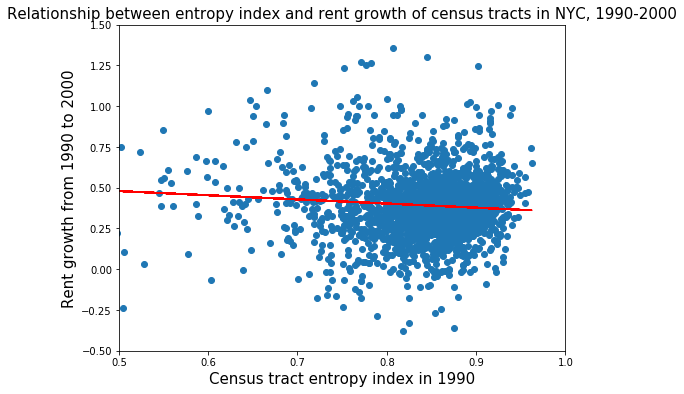

In [88]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy_rent.entropy_index_9, df_census_entropy_rent.rent_growth_90_00)
plt.plot(df_census_entropy_rent.entropy_index_9, lm1.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 1990-2000',
         fontsize = 15)
plt.xlim(0.5, 1.0)
plt.ylim(-0.5,1.5)
print('Rent_growth_90to00 = {} * Tract_Entropy_Index_90 + {}, R-squared = {}'.format(round(lm1.params[1],3),
                                                            round(lm1.params[0],3),round(lm1.rsquared,3)))

Rent_growth_00to10 = -0.16 * Tract_Entropy_Index_00 + 0.692, R-squared = 0.002


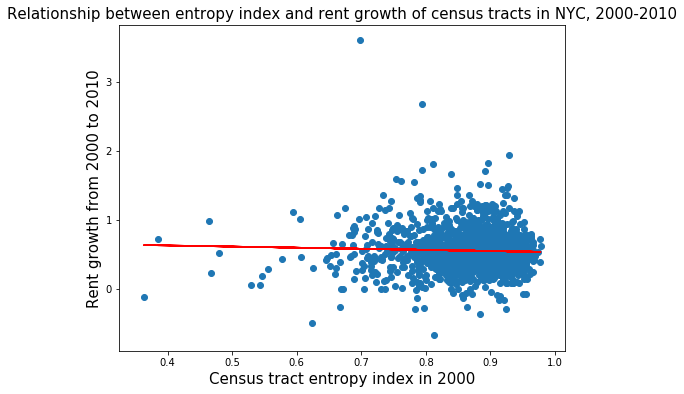

In [89]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy_rent.entropy_index_0, df_census_entropy_rent.rent_growth_00_10)
plt.plot(df_census_entropy_rent.entropy_index_0, lm2.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} * Tract_Entropy_Index_00 + {}, R-squared = {}'.format(round(lm2.params[1],3),
                                                            round(lm2.params[0],3),round(lm2.rsquared,3)))

# 4. Analysis based on PUMA neighborhoods

## 1） the whole picture for PUMAs 
- group by PUMA
- based on df2, to calculate median value of each variables for each PUMA
- based on df_family_income, to count the sum of each income leve group in 3 years, for each PUMA

In [90]:
df2.groupby(by = 'PUMA').median().iloc[:,1:].shape

(55, 13)

In [91]:
df_PUMA.rename(columns = {'PUMA \rCode':'PUMA'}, inplace=True)

In [92]:
df_puma_median = df_PUMA.merge(df2.groupby(by = 'PUMA').median().iloc[:,1:].reset_index(),
                               on = 'PUMA')
df_puma_median.head()

,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
0,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA",44167.0,494.0,51299.0,700.0,62159.0,1085.0,0.140436,0.166318,0.198781,0.231193,0.308582,0.434646,0.493617
1,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA",39708.5,531.5,46601.0,724.0,59099.5,1096.5,0.168343,0.193987,0.223715,0.163844,0.302899,0.356505,0.483344
2,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA",47155.0,575.0,52801.0,782.0,67596.0,1134.0,0.147156,0.170217,0.189952,0.264234,0.274448,0.342715,0.522135
3,3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA",36393.5,523.5,40273.0,733.0,57014.0,1059.5,0.167861,0.194978,0.218396,0.133348,0.297460,0.395233,0.490328
4,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA",13400.0,356.0,19793.0,536.5,26319.5,837.5,0.308408,0.288862,0.369311,0.467691,0.272902,0.392545,0.587491


In [93]:
df_puma_median.shape

(55, 16)

### We have 55 PUMAs for analysis.

In [94]:
df_puma_family_income = df_PUMA.merge(df_family_income.groupby(by = 'PUMA').sum()\
                                        .drop(['census_tract'], axis = 1),
                               left_on = 'PUMA', right_index = True)
df_puma_family_income.head()

,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
0,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA",1512,818,858,691,743,1769,1789,...,1106,1033,875,1997,2480,3003,2440,1359,1350,1923
1,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA",1430,841,1058,1072,1117,2086,2150,...,1793,1375,1531,2759,3667,5116,2928,1458,1478,495
2,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA",961,717,979,874,775,2037,2191,...,1276,1386,1154,1952,3071,4514,3172,2069,1525,826
3,3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA",1656,856,1013,969,1159,2035,1725,...,1344,1404,1383,2680,3547,4051,2565,1453,1153,517
4,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA",5270,1273,1255,1270,770,1594,1029,...,2134,1438,1374,2006,2054,1976,875,363,191,37


In [95]:
df_puma_family_income.shape

(55, 49)

## 2) Calculation of PUMA entropy index of 1990, 2000 and 2010

In [96]:
for i in df_puma_family_income.index:
    df_puma_family_income.loc[i,'entropy_index_9'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_109':'fam_inc_max_9']))
    df_puma_family_income.loc[i,'entropy_index_0'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_100':'fam_inc_max_200']))
    df_puma_family_income.loc[i,'entropy_index_1'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [97]:
df_puma_entropy = df_PUMA.merge(df_puma_family_income.loc[:, ['PUMA','entropy_index_9',
                                           'entropy_index_0','entropy_index_1']],
                               on = 'PUMA')

df_puma_entropy['entropy_index_change_90_00'] = \
                df_puma_entropy.entropy_index_0/df_puma_entropy.entropy_index_9 - 1
df_puma_entropy['entropy_index_change_00_10'] = \
                df_puma_entropy.entropy_index_1/df_puma_entropy.entropy_index_0 - 1

df_puma_entropy['mean_entropy'] = (df_puma_entropy.entropy_index_9 + \
                                   df_puma_entropy.entropy_index_0 + \
                                   df_puma_entropy.entropy_index_1)/3

df_puma_entropy.head()

,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,mean_entropy
0,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA",0.947997,0.971912,0.971036,0.025227,-0.000901,0.963648
1,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA",0.914075,0.952123,0.956327,0.041624,0.004415,0.940842
2,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA",0.905603,0.938712,0.945460,0.036561,0.007189,0.929925
3,3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA",0.927587,0.952514,0.958739,0.026873,0.006536,0.946280
4,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA",0.820355,0.831354,0.896695,0.013407,0.078596,0.849468


In [98]:
df_puma_entropy.shape

(55, 9)

The median values of income entropy index of PUMAs in 1999, 2000 and 2010 are respectively 0.945, 0.945 and 0.957.


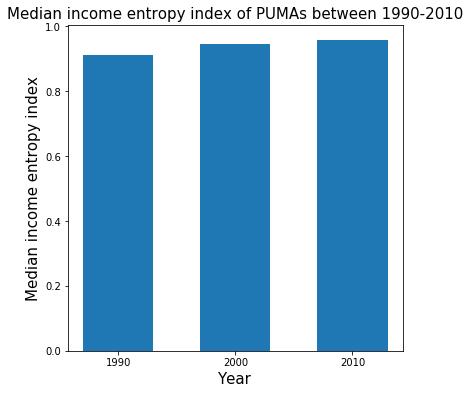

In [99]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_puma_entropy.median().loc[['entropy_index_9',
                                        'entropy_index_0','entropy_index_1']], width = 0.6)

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Median income entropy index of PUMAs between 1990-2010', fontsize = 15)

print('The median values of income entropy index of PUMAs in 1999, 2000 and 2010 are respectively {}, {} and {}.'.\
      format(round(df_puma_entropy.median().loc['entropy_index_0'],3), 
             round(df_puma_entropy.median().loc['entropy_index_0'],3), 
             round(df_puma_entropy.median().loc['entropy_index_1'],3)))

## The income entropy index of PUMAs increased in the 20 years, meaning the level of neighborhood income integration in total has increased

### Then, we have a look at the variance of different PUMA's entropy index and their change in 20 years

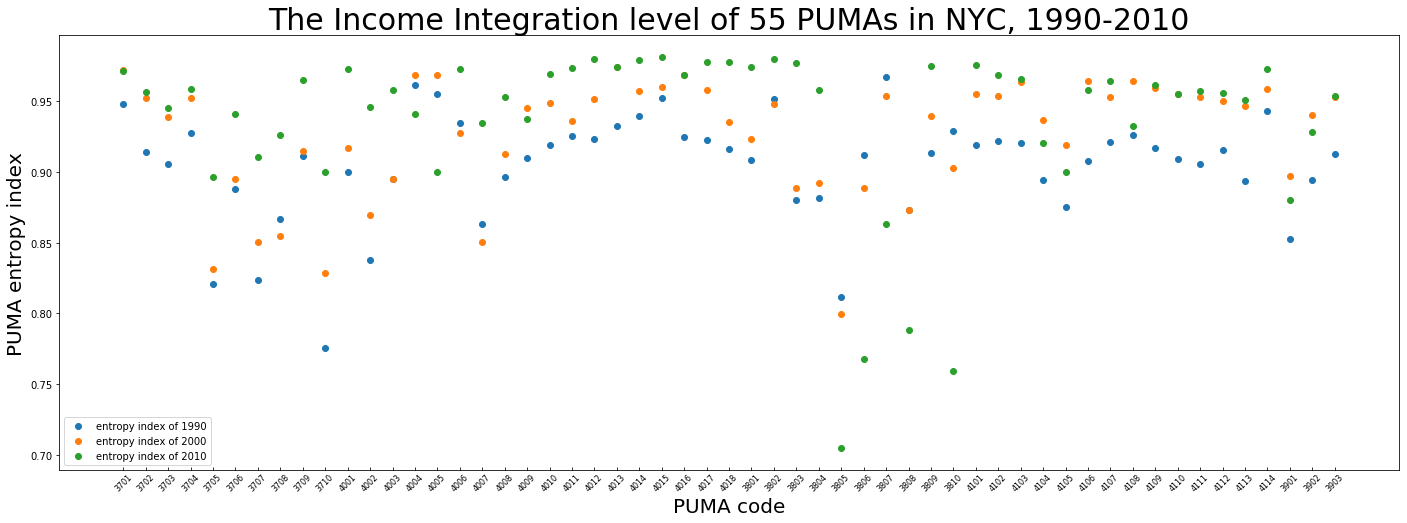

In [100]:
## to see the distribution of entropy index
plt.figure(figsize = (24, 8))
plt.scatter(np.arange(len(df_puma_entropy)),df_puma_entropy.entropy_index_9,
           label = 'entropy index of 1990')
plt.scatter(np.arange(len(df_puma_entropy)),df_puma_entropy.entropy_index_0,
           label = 'entropy index of 2000')
plt.scatter(np.arange(len(df_puma_entropy)),df_puma_entropy.entropy_index_1,
           label = 'entropy index of 2010')
plt.legend()

plt.xticks(np.arange(len(df_puma_entropy)), df_puma_entropy.PUMA, rotation = 45, 
                  fontsize = 15)
plt.tick_params(axis='x', pad = 2, labelsize = 8, direction = 'in')
plt.ylabel('PUMA entropy index', fontsize = 20)
plt.xlabel('PUMA code', fontsize = 20)
plt.title('The Income Integration level of 55 PUMAs in NYC, 1990-2010', fontsize = 30)
plt.show()

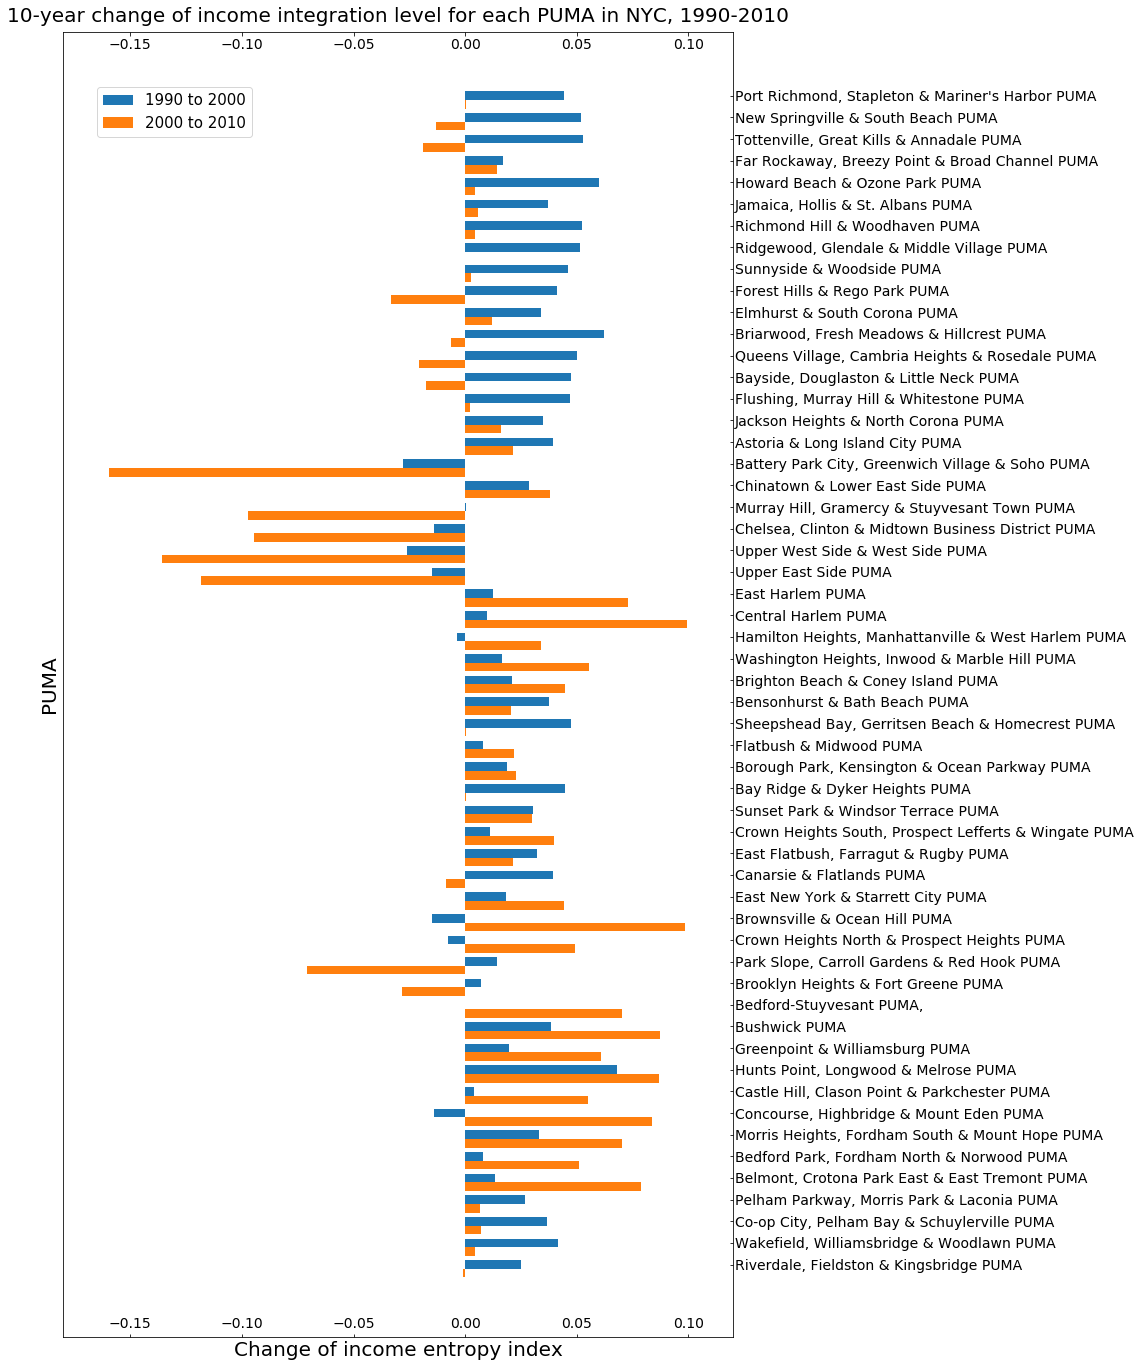

In [101]:
## To see the change of entropy index in the PUMAs
plt.figure(figsize = (12, 24))
plt.barh(np.arange(len(df_puma_entropy)), 
         width = df_puma_entropy.entropy_index_change_90_00,
        height = 0.4, label = '1990 to 2000')
plt.barh(np.arange(len(df_puma_entropy)) - 0.4, 
         width = df_puma_entropy.entropy_index_change_00_10,
        height = 0.4, label = '2000 to 2010')
plt.xlim((-0.18,0.12))
plt.tick_params(axis='x', pad= -20, labelsize=14, direction = 'in', 
                top = True, bottom = True, labeltop= True, labelbottom = True)
plt.yticks(np.arange(len(df_puma_entropy)),df_puma_entropy.PUMA_neighborhoods )
plt.tick_params(axis='y', pad=2, labelsize=14, direction = 'in', 
               left = False, right = True, labelleft = False, labelright = True)

plt.ylabel('PUMA',fontsize = 20)
plt.xlabel('Change of income entropy index', fontsize = 20)
plt.title('10-year change of income integration level for each PUMA in NYC, 1990-2010',fontsize = 20,
         verticalalignment='bottom')

plt.legend(loc = (0.05, 0.92), fontsize = 15)
plt.show()

## If we look at different PUMAs, the change of income entropy index varies, especially in Manhattan and Brooklyn.  
## In Manhattan, most of the entropy index continued to decrease in 20 years, even getting worse in the latter decade.
## On the contrary, in brooklyn, most of the entropy index continued to increase in 20 years, with greater growth rate in the latter decade.

## 3) Combine PUMA entropy index and rent growth

In [102]:
df_puma_entropy_rent = df_puma_entropy.merge(df_puma_median.loc[:,['PUMA',
                                    'median_rent_9','median_rent_0','median_rent_1',
                                    'rent_growth_90_00','rent_growth_00_10']], 
                                                  on = 'PUMA' )

df_puma_entropy_rent.head()

,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,mean_entropy,median_rent_9,median_rent_0,median_rent_1,rent_growth_90_00,rent_growth_00_10
0,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA",0.947997,0.971912,0.971036,0.025227,-0.000901,0.963648,494.0,700.0,1085.0,0.434646,0.493617
1,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA",0.914075,0.952123,0.956327,0.041624,0.004415,0.940842,531.5,724.0,1096.5,0.356505,0.483344
2,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA",0.905603,0.938712,0.945460,0.036561,0.007189,0.929925,575.0,782.0,1134.0,0.342715,0.522135
3,3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA",0.927587,0.952514,0.958739,0.026873,0.006536,0.946280,523.5,733.0,1059.5,0.395233,0.490328
4,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA",0.820355,0.831354,0.896695,0.013407,0.078596,0.849468,356.0,536.5,837.5,0.392545,0.587491


## This is the Table on PUMA level for entropy index and rent growth!

In [103]:
df_puma_entropy_rent.shape

(55, 14)

In [104]:
df_puma_entropy_rent.describe()

,PUMA,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,mean_entropy,median_rent_9,median_rent_0,median_rent_1,rent_growth_90_00,rent_growth_00_10
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,3936.218182,0.904434,0.926655,0.936620,0.024697,0.011200,0.922569,533.536364,749.081818,1157.672727,0.405589,0.535191
std,149.997616,0.038194,0.041904,0.058821,0.023504,0.055796,0.039299,114.797642,179.598466,281.730453,0.123951,0.096325
min,3701.000000,0.775501,0.799350,0.704571,-0.028063,-0.159737,0.771796,316.000000,395.000000,676.000000,0.200278,0.316534
25%,3804.500000,0.893855,0.900103,0.930343,0.008814,-0.003511,0.913047,444.500000,642.000000,983.500000,0.341770,0.477475
50%,4005.000000,0.912587,0.945421,0.957218,0.028580,0.012050,0.939680,523.500000,733.000000,1118.000000,0.392936,0.520751
75%,4059.500000,0.924997,0.955290,0.972830,0.042930,0.046946,0.946257,610.500000,794.250000,1210.000000,0.432845,0.575999
max,4114.000000,0.966913,0.973947,0.981136,0.068091,0.099543,0.964678,860.000000,1306.000000,1999.000000,0.826174,0.821794


In [105]:
df_puma_entropy.columns

Index([u'PUMA', u'PUMA_CommunityDistrict', u'PUMA_neighborhoods',
       u'entropy_index_9', u'entropy_index_0', u'entropy_index_1',
       u'entropy_index_change_90_00', u'entropy_index_change_00_10',
       u'mean_entropy'],
      dtype='object')

In [106]:
df_puma_median.columns

Index([u'PUMA', u'PUMA_CommunityDistrict', u'PUMA_neighborhoods',
       u'median_inc_fam_9', u'median_rent_9', u'median_inc_fam_0',
       u'median_rent_0', u'median_inc_fam_1', u'median_rent_1',
       u'rent_income_ratio_9', u'rent_income_ratio_0', u'rent_income_ratio_1',
       u'inc_growth_90_00', u'inc_growth_00_10', u'rent_growth_90_00',
       u'rent_growth_00_10'],
      dtype='object')

In [107]:
df_puma_analysis = df_puma_entropy.merge(df_puma_median, 
                            on = ['PUMA', 'PUMA_CommunityDistrict','PUMA_neighborhoods'])
df_puma_analysis.head()

,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,mean_entropy,median_inc_fam_9,...,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
0,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA",0.947997,0.971912,0.971036,0.025227,-0.000901,0.963648,44167.0,...,700.0,62159.0,1085.0,0.140436,0.166318,0.198781,0.231193,0.308582,0.434646,0.493617
1,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA",0.914075,0.952123,0.956327,0.041624,0.004415,0.940842,39708.5,...,724.0,59099.5,1096.5,0.168343,0.193987,0.223715,0.163844,0.302899,0.356505,0.483344
2,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA",0.905603,0.938712,0.945460,0.036561,0.007189,0.929925,47155.0,...,782.0,67596.0,1134.0,0.147156,0.170217,0.189952,0.264234,0.274448,0.342715,0.522135
3,3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA",0.927587,0.952514,0.958739,0.026873,0.006536,0.946280,36393.5,...,733.0,57014.0,1059.5,0.167861,0.194978,0.218396,0.133348,0.297460,0.395233,0.490328
4,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA",0.820355,0.831354,0.896695,0.013407,0.078596,0.849468,13400.0,...,536.5,26319.5,837.5,0.308408,0.288862,0.369311,0.467691,0.272902,0.392545,0.587491


## Above table has all the variables we need for analysis at the PUMA level !!!

In [108]:
df_puma_analysis.columns

Index([u'PUMA', u'PUMA_CommunityDistrict', u'PUMA_neighborhoods',
       u'entropy_index_9', u'entropy_index_0', u'entropy_index_1',
       u'entropy_index_change_90_00', u'entropy_index_change_00_10',
       u'mean_entropy', u'median_inc_fam_9', u'median_rent_9',
       u'median_inc_fam_0', u'median_rent_0', u'median_inc_fam_1',
       u'median_rent_1', u'rent_income_ratio_9', u'rent_income_ratio_0',
       u'rent_income_ratio_1', u'inc_growth_90_00', u'inc_growth_00_10',
       u'rent_growth_90_00', u'rent_growth_00_10'],
      dtype='object')

In [109]:
df_puma_analysis.shape

(55, 22)

In [110]:
df_puma_analysis.describe()

,PUMA,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,mean_entropy,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,3936.218182,0.904434,0.926655,0.936620,0.024697,0.011200,0.922569,36287.427273,533.536364,47487.909091,749.081818,64820.800000,1157.672727,0.193852,0.210939,0.240003,0.288070,0.354350,0.405589,0.535191
std,149.997616,0.038194,0.041904,0.058821,0.023504,0.055796,0.039299,15727.450220,114.797642,25552.766438,179.598466,37552.782138,281.730453,0.051633,0.051440,0.063868,0.150773,0.107568,0.123951,0.096325
min,3701.000000,0.775501,0.799350,0.704571,-0.028063,-0.159737,0.771796,11733.000000,316.000000,19793.000000,395.000000,25231.500000,676.000000,0.106820,0.110028,0.106927,0.094395,0.171429,0.200278,0.316534
25%,3804.500000,0.893855,0.900103,0.930343,0.008814,-0.003511,0.913047,23557.500000,444.500000,31129.750000,642.000000,42219.250000,983.500000,0.158061,0.175129,0.201150,0.196328,0.287231,0.341770,0.477475
50%,4005.000000,0.912587,0.945421,0.957218,0.028580,0.012050,0.939680,35304.500000,523.500000,40284.000000,733.000000,56530.000000,1118.000000,0.185874,0.206794,0.239073,0.239864,0.324492,0.392936,0.520751
75%,4059.500000,0.924997,0.955290,0.972830,0.042930,0.046946,0.946257,43333.500000,610.500000,54504.750000,794.250000,69783.000000,1210.000000,0.216930,0.237325,0.283081,0.360434,0.428492,0.432845,0.575999
max,4114.000000,0.966913,0.973947,0.981136,0.068091,0.099543,0.964678,88298.000000,860.000000,143223.000000,1306.000000,205250.000000,1999.000000,0.335313,0.341879,0.377673,0.778620,0.623702,0.826174,0.821794


#### Let's do Autocorrealation on geopands

In [111]:
PUMA_shp = gpd.read_file('data/PUMA/geo_export_4f8c3947-30de-49bb-8d33-eb3b18d82220.shp')

In [112]:
PUMA_shp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


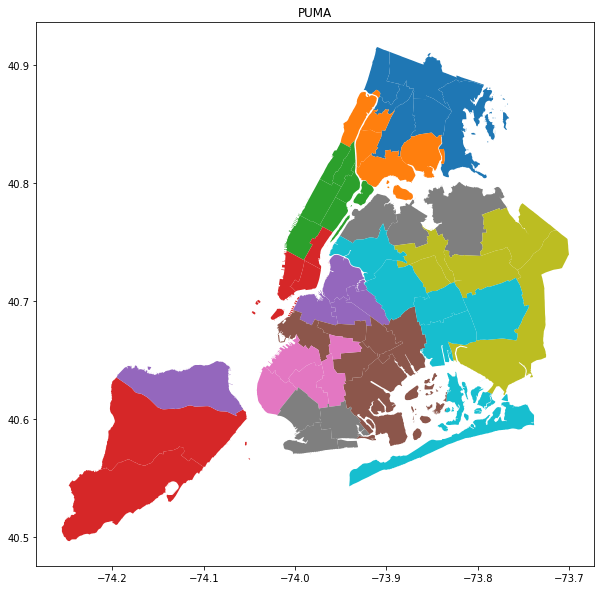

In [113]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
PUMA_shp.plot(column='puma', alpha =1, linewidth = 0.5, ax = ax)
plt.title('PUMA')

In [114]:
from fiona.crs import from_epsg
PUMA_shp.crc = from_epsg(4326)
NYC_Area=PUMA_shp.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7)
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5])

total NYC land area: 302.3 (mi^2)


/usr/local/lib/python2.7/dist-packages/geopandas/geodataframe.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


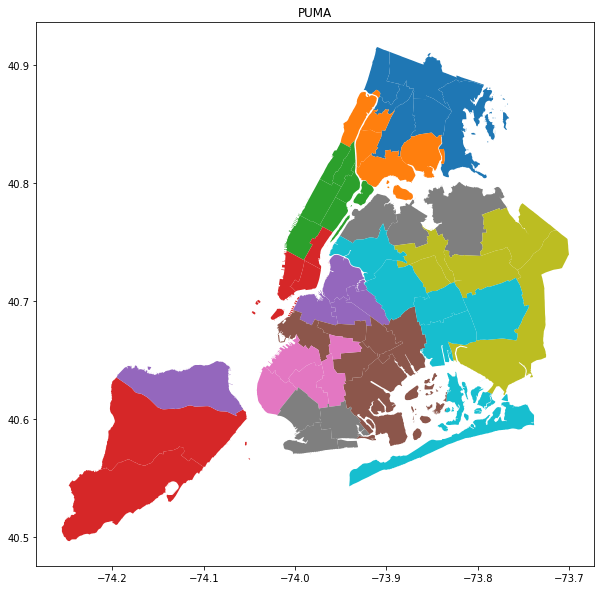

In [115]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
PUMA_shp.plot(column='puma', alpha =1, linewidth = 0.5, ax = ax)
plt.title('PUMA')

#### Let's add df_PUMA analysis data on PUMA.shape file

In [116]:
PUMA_shp = PUMA_shp.join(df_puma_analysis)

In [117]:
PUMA_shp.columns

Index([                      u'puma',                 u'shape_leng',
                       u'shape_area',                   u'geometry',
                             u'PUMA',     u'PUMA_CommunityDistrict',
               u'PUMA_neighborhoods',            u'entropy_index_9',
                  u'entropy_index_0',            u'entropy_index_1',
       u'entropy_index_change_90_00', u'entropy_index_change_00_10',
                     u'mean_entropy',           u'median_inc_fam_9',
                    u'median_rent_9',           u'median_inc_fam_0',
                    u'median_rent_0',           u'median_inc_fam_1',
                    u'median_rent_1',        u'rent_income_ratio_9',
              u'rent_income_ratio_0',        u'rent_income_ratio_1',
                 u'inc_growth_90_00',           u'inc_growth_00_10',
                u'rent_growth_90_00',          u'rent_growth_00_10'],
      dtype='object')

In [118]:
PUMA_shp['entropy_change']  = ((PUMA_shp['entropy_index_1'] - PUMA_shp['entropy_index_9']) / PUMA_shp['entropy_index_9']) * 100

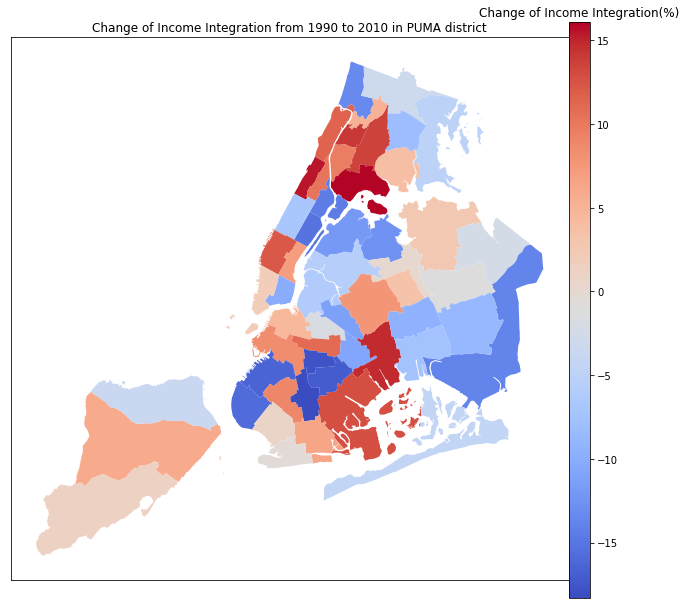

In [119]:
f, ax = plt.subplots(figsize=(10,10))
vmin, vmax = min(PUMA_shp['entropy_change']) , max(PUMA_shp['entropy_change'])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
PUMA_shp.plot(column='entropy_change', categorical = True, cmap = 'coolwarm', alpha =1, linewidth = 2, ax = ax)
plt.title('Change of Income Integration from 1990 to 2010 in PUMA district')

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

plt.title('Change of Income Integration(%)')

In [120]:
(PUMA_shp['rent_income_ratio_1'] - PUMA_shp['rent_income_ratio_9']) / PUMA_shp['rent_income_ratio_9'] * 100

0     41.545235
1     32.892426
2     29.081909
3     30.105138
4     19.747610
5     61.287137
6     12.632995
7      6.765331
8     38.339674
9      7.529145
10    43.912230
11     3.178812
12    26.002146
13     5.005007
14    -3.787884
15    28.436550
16    24.971613
17    23.324042
18    24.687299
19    21.290416
20    30.030949
21    43.811184
22    32.508226
23    49.674885
24    34.461318
25    34.377892
26    32.719517
27     6.519873
28    21.677452
29    25.380882
30     6.283964
31     6.930971
32     6.391110
33    -0.271328
34     1.726486
35    28.180050
36    18.754958
37    -0.491214
38    31.325815
39    35.468371
40    27.513269
41    28.930967
42    -0.496835
43    43.952622
44    43.559034
45    25.348845
46    43.712063
47    36.553522
48    34.489785
49    17.567535
50    32.679558
51    14.429048
52    12.304083
53     7.383470
54    36.827954
dtype: float64

In [121]:
PUMA_shp['rent_income_change'] = (PUMA_shp['rent_income_ratio_1'] - PUMA_shp['rent_income_ratio_9']) / PUMA_shp['rent_income_ratio_9'] * 100

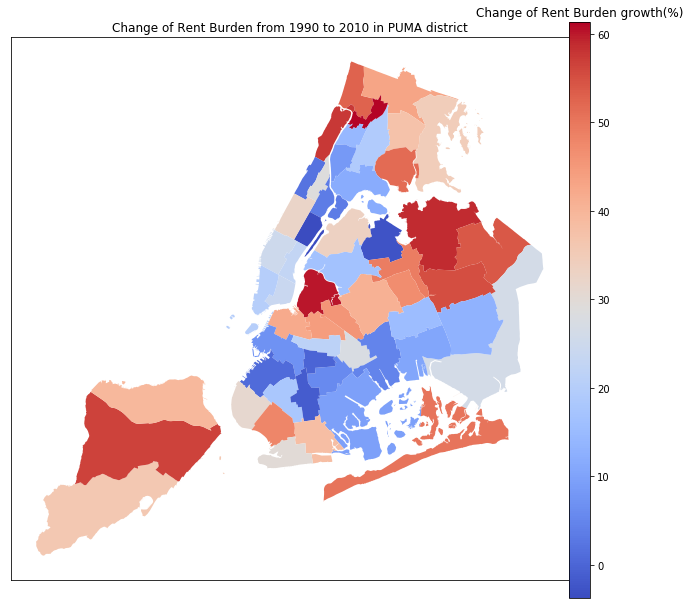

In [122]:
f, ax = plt.subplots(figsize=(10,10))
vmin, vmax = min(PUMA_shp['rent_income_change']) , max(PUMA_shp['rent_income_change'])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
PUMA_shp.plot(column='rent_income_change', categorical = True, cmap = 'coolwarm', alpha =1, linewidth = 2, ax = ax)
plt.title('Change of Rent Burden from 1990 to 2010 in PUMA district')

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

plt.title('Change of Rent Burden growth(%)')

In [123]:
PUMA_shp['inc_change'] = ((PUMA_shp['median_inc_fam_1'] - PUMA_shp['median_inc_fam_9']) / PUMA_shp['median_inc_fam_9'])* 100

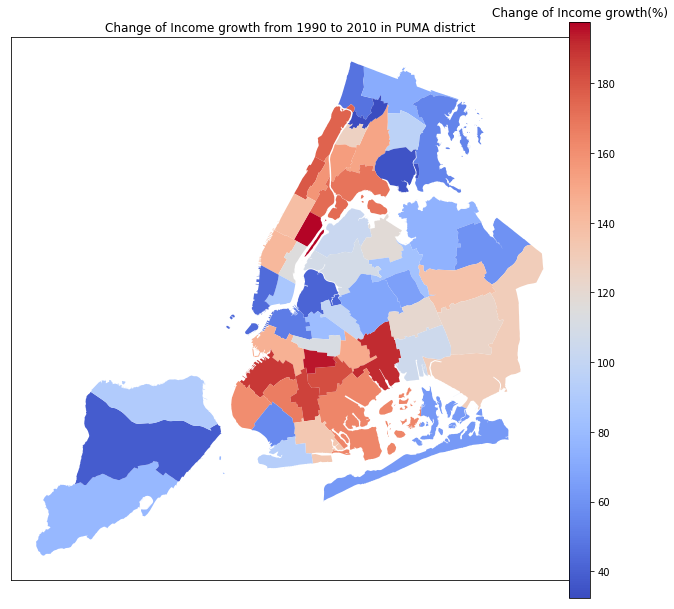

In [124]:

f, ax = plt.subplots(figsize=(10,10))
vmin, vmax = min(PUMA_shp['inc_change']) , max(PUMA_shp['inc_change'])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
PUMA_shp.plot(column='inc_change', categorical = True, cmap = 'coolwarm', alpha =1, linewidth = 2, ax = ax)
plt.title('Change of Income growth from 1990 to 2010 in PUMA district')

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

plt.title('Change of Income growth(%)')

In [125]:
PUMA_shp['rent_change'] = ((PUMA_shp['median_rent_1'] - PUMA_shp['median_rent_9']) / PUMA_shp['median_rent_9']) * 100

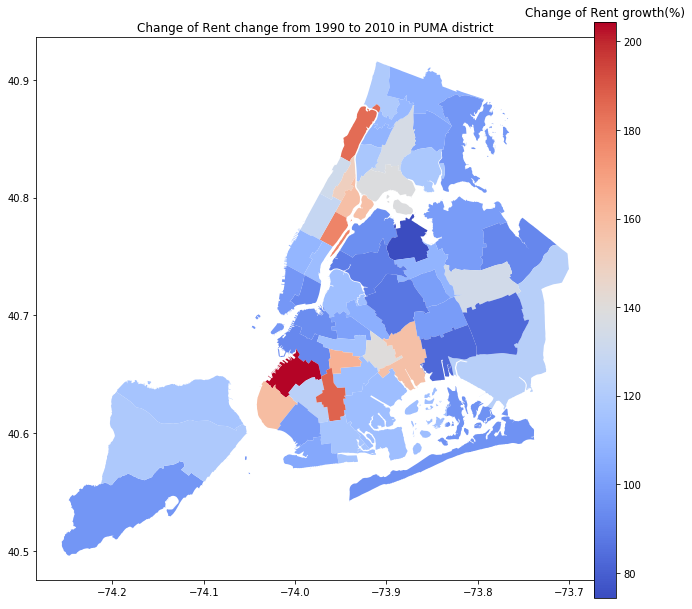

In [126]:
f, ax = plt.subplots(figsize=(10,10))
vmin, vmax = min(PUMA_shp['rent_change']) , max(PUMA_shp['rent_change'])
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
PUMA_shp.plot(column='rent_change',cmap = 'coolwarm' ,alpha =1, linewidth = 0.5, ax = ax)
plt.title('Change of Rent change from 1990 to 2010 in PUMA district')

fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

plt.title('Change of Rent growth(%)')

In [127]:
import pysal as ps

In [128]:
PUMA_shp.crs

{'init': u'epsg:4326'}

In [129]:
qW_PUMA = ps.queen_from_shapefile('data/PUMA/geo_export_4f8c3947-30de-49bb-8d33-eb3b18d82220.shp')

In [130]:
rW_PUMA = ps.weights.Rook.from_shapefile('data/PUMA/geo_export_4f8c3947-30de-49bb-8d33-eb3b18d82220.shp')

In [131]:
WQmatrix, ids = qW_PUMA.full()

In [132]:
WQmatrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [133]:
WRmatrix, ids = rW_PUMA.full()

In [134]:
WRmatrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

#### change the matrix to be row-standardized

#### Queen

In [135]:
qW_PUMA.transform = 'r'

#### Rook

In [136]:
rW_PUMA.transform = 'r'

#### Moran's I  -> It should use Rook boundary, according to the original paper

In [137]:
rentChange = PUMA_shp.rent_change
rentChangeLag = ps.lag_spatial(rW_PUMA, rentChange)

incomeChange = PUMA_shp.inc_change
incomeChangeLag = ps.lag_spatial(rW_PUMA, incomeChange)

entropyChange = PUMA_shp.entropy_change
entropyChangeLag = ps.lag_spatial(rW_PUMA, entropyChange)

rentburdenChange = PUMA_shp.rent_income_change
rentburdenChangeLag = ps.lag_spatial(rW_PUMA, rentburdenChange)



In [138]:
Lrentburdenchange_q = ps.Moran_Local(rentburdenChange, qW_PUMA,permutations=999)

In [139]:
Lrentburdenchange_r = ps.Moran_Local(rentburdenChange, rW_PUMA,permutations=999)

#### Create Quantiles for mapping

In [140]:
rentChangeLagQ4 = ps.Quantiles(rentChangeLag, k = 4)

incomeChangelagQ4 = ps.Quantiles(incomeChangeLag, k = 4)

entropyChangelagQ4 = ps.Quantiles(entropyChangeLag, k = 4)

rentburdenChangelagQ4 = ps.Quantiles(rentburdenChangeLag, k = 4)

In [141]:
rentChangeLagQ4

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <= 107.102               14
107.102 < x[i] <= 118.000               14
118.000 < x[i] <= 128.695               13
128.695 < x[i] <= 154.259               14

In [142]:
incomeChangelagQ4

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  60.683               14
 60.683 < x[i] <=  74.553               14
 74.553 < x[i] <=  95.342               13
 95.342 < x[i] <= 123.619               14

In [143]:
entropyChangelagQ4

               Quantiles                
 
Lower            Upper             Count
         x[i] <=  2.557               14
 2.557 < x[i] <=  4.682               14
 4.682 < x[i] <=  5.934               13
 5.934 < x[i] <= 11.976               14

In [144]:
rentburdenChangelagQ4

               Quantiles                
 
Lower            Upper             Count
         x[i] <= 17.418               14
17.418 < x[i] <= 24.772               14
24.772 < x[i] <= 30.261               13
30.261 < x[i] <= 46.031               14

#### Let's map it!. Actually, it has to be quantile, HH, HL, LH, LL

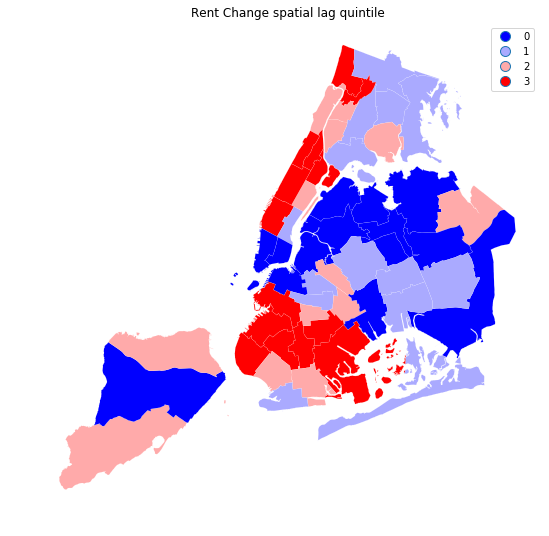

In [145]:
f, ax = plt.subplots(figsize=(9, 9))
PUMA_shp.assign(cl=rentChangeLagQ4.yb).plot(column='cl', categorical=True, 
        k=4, cmap='bwr', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Rent Change spatial lag quintile")

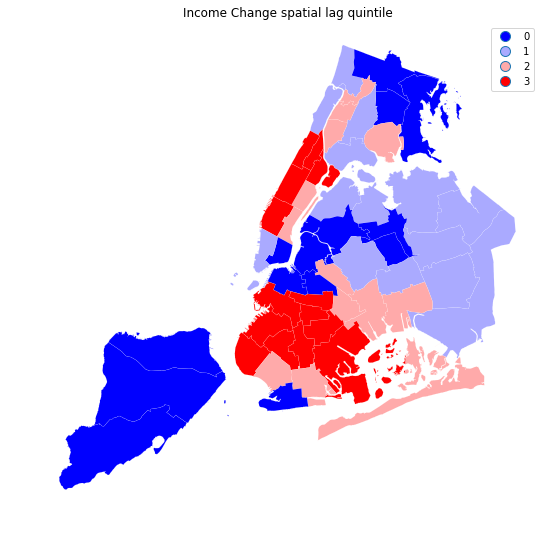

In [146]:
f, ax = plt.subplots(figsize=(9, 9))
PUMA_shp.assign(cl=incomeChangelagQ4.yb).plot(column='cl', categorical=True, 
        k=4, cmap='bwr', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Income Change spatial lag quintile")

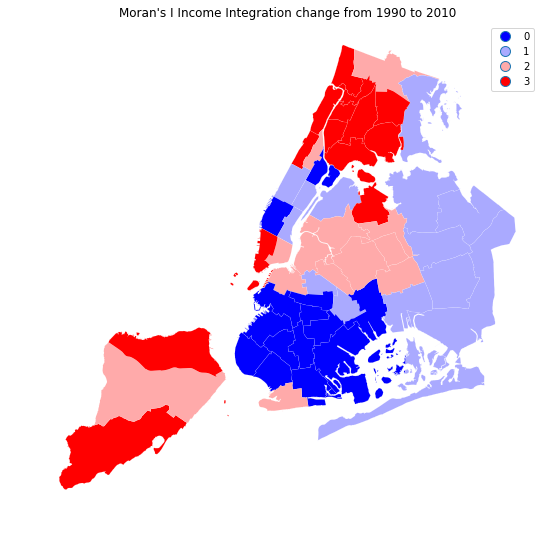

In [147]:
f, ax = plt.subplots(figsize=(9, 9))
PUMA_shp.assign(cl=entropyChangelagQ4.yb).plot(column='cl', categorical=True, 
        k=4, cmap='bwr', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Moran's I Income Integration change from 1990 to 2010")

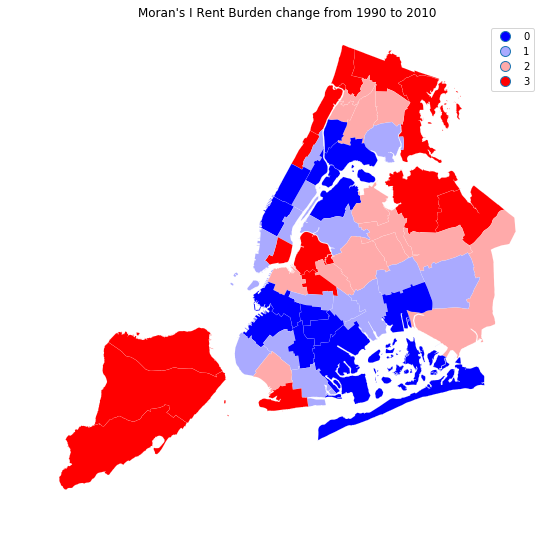

In [148]:
f, ax = plt.subplots(figsize=(9, 9))
PUMA_shp.assign(cl=rentburdenChangelagQ4.yb).plot(column='cl', categorical=True, 
        k=4, cmap='bwr', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Moran's I Rent Burden change from 1990 to 2010")

In [149]:
b,a = np.polyfit(incomeChange, incomeChangeLag, 1)

In [150]:
b1,a1 = np.polyfit(rentChange, rentChangeLag, 1)

In [151]:
b2, a2, =np.polyfit(entropyChange, entropyChangeLag, 1)

In [152]:
b3,a3 = np.polyfit(rentburdenChange, rentburdenChangeLag, 1)

#### Moran Scatterplot

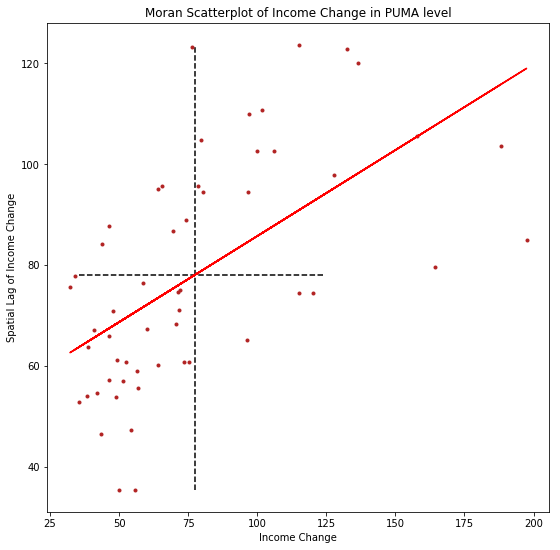

In [153]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(incomeChange, incomeChangeLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(incomeChange.mean(), incomeChangeLag.min(), incomeChangeLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(incomeChangeLag.mean(), incomeChangeLag.min(), incomeChangeLag.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(incomeChange, a + b*incomeChange, 'r')
plt.title('Moran Scatterplot of Income Change in PUMA level')
plt.ylabel('Spatial Lag of Income Change')
plt.xlabel('Income Change')

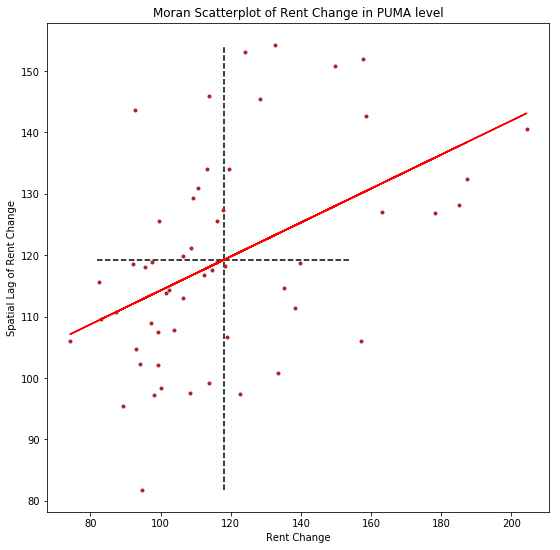

In [154]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(rentChange, rentChangeLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(rentChange.mean(), rentChangeLag.min(), rentChangeLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(rentChangeLag.mean(), rentChangeLag.min(), rentChangeLag.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(rentChange, a1 + b1 * rentChange, 'r')
plt.title('Moran Scatterplot of Rent Change in PUMA level')
plt.ylabel('Spatial Lag of Rent Change')
plt.xlabel('Rent Change')

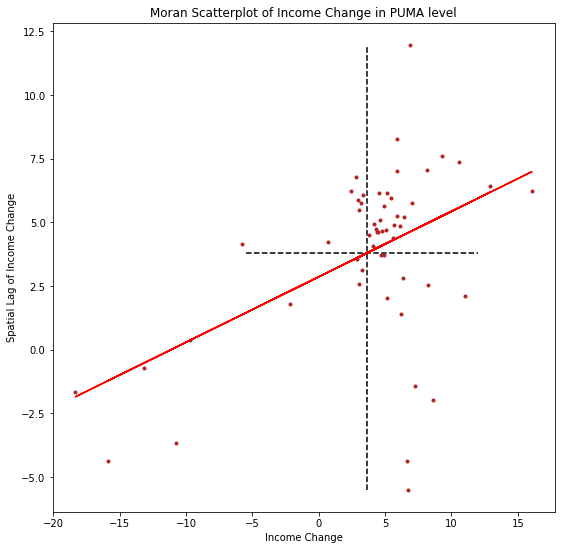

In [155]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(entropyChange, entropyChangeLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(entropyChange.mean(), entropyChangeLag.min(), entropyChangeLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(entropyChangeLag.mean(), entropyChangeLag.min(), entropyChangeLag.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(entropyChange, a2 + b2 * entropyChange, 'r')
plt.title('Moran Scatterplot of Income Change in PUMA level')
plt.ylabel('Spatial Lag of Income Change')
plt.xlabel('Income Change')

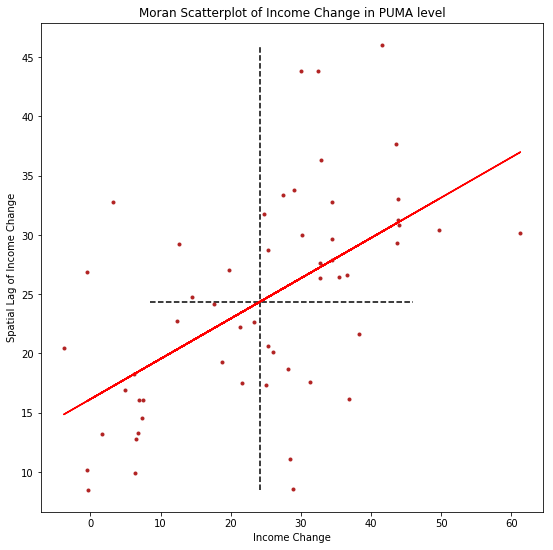

In [156]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(rentburdenChange, rentburdenChangeLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(rentburdenChange.mean(), rentburdenChangeLag.min(), rentburdenChangeLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(rentburdenChangeLag.mean(), rentburdenChangeLag.min(), rentburdenChangeLag.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(rentburdenChange, a3 + b3 * rentburdenChange, 'r')
plt.title('Moran Scatterplot of Income Change in PUMA level')
plt.ylabel('Spatial Lag of Income Change')
plt.xlabel('Income Change')

In [157]:
PUMA_shp.head()

,puma,shape_leng,shape_area,geometry,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,entropy_index_9,entropy_index_0,entropy_index_1,...,rent_income_ratio_0,rent_income_ratio_1,inc_growth_90_00,inc_growth_00_10,rent_growth_90_00,rent_growth_00_10,entropy_change,rent_income_change,inc_change,rent_change
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,3701,Bronx Community District 8,"Riverdale, Fieldston & Kingsbridge PUMA",0.947997,0.971912,0.971036,...,0.166318,0.198781,0.231193,0.308582,0.434646,0.493617,2.430334,41.545235,40.736296,119.635628
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,3702,Bronx Community District 12,"Wakefield, Williamsbridge & Woodlawn PUMA",0.914075,0.952123,0.956327,...,0.193987,0.223715,0.163844,0.302899,0.356505,0.483344,4.622353,32.892426,48.833373,106.302916
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,Bronx Community District 10,"Co-op City, Pelham Bay & Schuylerville PUMA",0.905603,0.938712,0.945460,...,0.170217,0.189952,0.264234,0.274448,0.342715,0.522135,4.401201,29.081909,43.348531,97.217391
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,Bronx Community District 11,"Pelham Parkway, Morris Park & Laconia PUMA",0.927587,0.952514,0.958739,...,0.194978,0.218396,0.133348,0.297460,0.395233,0.490328,3.358387,30.105138,56.659843,102.387775
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,3705,Bronx Community District 3 & 6,"Belmont, Crotona Park East & East Tremont PUMA",0.820355,0.831354,0.896695,...,0.288862,0.369311,0.467691,0.272902,0.392545,0.587491,9.305687,19.747610,96.414179,135.252809


In [158]:
rentburden_9 = PUMA_shp.rent_income_ratio_9
rentburden_0 = PUMA_shp.rent_income_ratio_0
rentburden_1 = PUMA_shp.rent_income_ratio_1

In [159]:
rentburden_9.median(), rentburden_0.median(), rentburden_1.median(),

(0.18587409810021843, 0.20679422100741898, 0.23907274752168953)

In [160]:
I_rentburden_1990_q = ps.Moran(rentburden_9, qW_PUMA)
I_rentburden_1990_q.I, I_rentburden_1990_q.p_sim

I_rentburden_2000_q = ps.Moran(rentburden_0, qW_PUMA)
I_rentburden_2000_q.I, I_rentburden_2000_q.p_sim

I_rentburden_2010_q = ps.Moran(rentburden_1, qW_PUMA)
I_rentburden_2010_q.I, I_rentburden_2010_q.p_sim


(0.32891622992005232, 0.002)

In [161]:
print ('1990 {:f}, and 2000 {:f}, and 2010 {:f} ').format(I_rentburden_1990_q.I,I_rentburden_2000_q.I,I_rentburden_2010_q.I)

1990 0.342080, and 2000 0.279865, and 2010 0.328916 


In [163]:
I_rentburden_q = ps.Moran(rentburdenChange, qW_PUMA)
I_rentburden_q.I, I_rentburden_q.p_sim


(0.33990846816254427, 0.001)

In [164]:
I_rentburden_r = ps.Moran(rentburdenChange, rW_PUMA)
I_rentburden_r.I, I_rentburden_r.p_sim

(0.33990522980865567, 0.001)

### local

In [165]:
Local_rentburden_q = ps.Moran_Local(rentburdenChange, qW_PUMA,permutations=999)

In [177]:
Local_rentburden_q.p_sim

array([ 0.005,  0.031,  0.114,  0.2  ,  0.28 ,  0.161,  0.298,  0.09 ,
        0.374,  0.136,  0.103,  0.188,  0.325,  0.18 ,  0.268,  0.019,
        0.216,  0.374,  0.166,  0.385,  0.09 ,  0.243,  0.085,  0.106,
        0.192,  0.08 ,  0.356,  0.02 ,  0.127,  0.296,  0.142,  0.099,
        0.003,  0.012,  0.056,  0.267,  0.209,  0.002,  0.16 ,  0.393,
        0.202,  0.073,  0.38 ,  0.18 ,  0.042,  0.244,  0.188,  0.32 ,
        0.32 ,  0.48 ,  0.263,  0.448,  0.407,  0.084,  0.24 ])

In [200]:
sig = Local_rentburden_q.p_sim<0.05
Local_rentburden_q.p_sim[sig]

array([ 0.005,  0.031,  0.019,  0.02 ,  0.003,  0.012,  0.002,  0.042])

In [181]:
Local_rentburden_q.q[sig]

array([1, 1, 4, 3, 3, 3, 3, 1])

In [167]:
# I_income_q = ps.Moran(incomeChange, qW_PUMA)
# I_income_q.I, I_income_q.p_sim
# I_rent_q = ps.Moran(rente)

In [168]:
sigs = rentburdenChange[Local_rentburden_q.p_sim <= .001]
W_sigs = rentburdenChange[Local_rentburden_q.p_sim <= .001]
insigs = rentburdenChange[Local_rentburden_q.p_sim > .001]
W_insigs = rentburdenChange[Local_rentburden_q.p_sim > .001]

In [201]:
import pysal as ps
import numpy as np
from pysal.contrib.viz import mapping as maps

In [202]:
shp_link = ps.examples.get_path('NAT.shp')
print 'Reading from ', shp_link

hr90 = np.array(ps.open(shp_link.replace('.shp', '.dbf')).by_col('HR90'))

Reading from  /usr/local/lib/python2.7/dist-packages/pysal/examples/nat/NAT.shp


In [203]:
_ = maps.plot_choropleth(shp_link, hr90, 'quantiles', cmap='Greens', figsize=(9, 6))

ValueError: Both *x_transform* and *y_transform* must be 2D affine transforms.

In [198]:
_ = maps.plot_lisa_cluster(PUMA_shp, Local_rentburden_q, figsize=(9, 6))

AttributeError: 'GeoDataFrame' object has no attribute 'rfind'

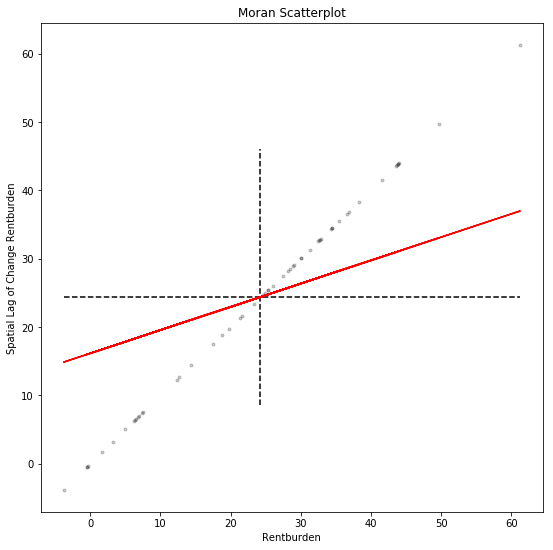

In [176]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
# plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(rentburdenChange.mean(), rentburdenChangeLag.min(), rentburdenChangeLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(rentburdenChangeLag.mean(), rentburdenChange.min(), rentburdenChange.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(rentburdenChange, a3 + b3 * rentburdenChange, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Change Rentburden')
plt.xlabel('Rentburden')

In [161]:
I_entropy_q = ps.Moran(entropyChange, qW_PUMA)
I_entropy_r = ps.Moran(entropyChange, rW_PUMA)
I_entropy_q
I_rentburden_q = ps.Moran(rentburdenChange, qW_PUMA)
I_rentburden_r = ps.Moran(rentburdenChange, rW_PUMA)

In [162]:
I_entropy_q.I, I_entropy_q.p_sim

(0.25771588096878723, 0.0080000000000000002)

In [163]:
I_entropy_r.I, I_entropy_r.p_sim

(0.25705207067095309, 0.012999999999999999)

In [164]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

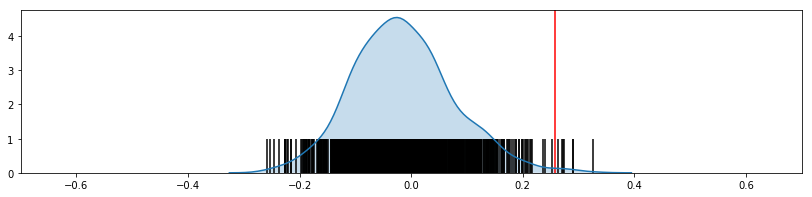

In [165]:
sns.kdeplot(I_entropy_q.sim, shade=True)
plt.vlines(I_entropy_q.sim, 0, 1)
plt.vlines(I_entropy_q.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

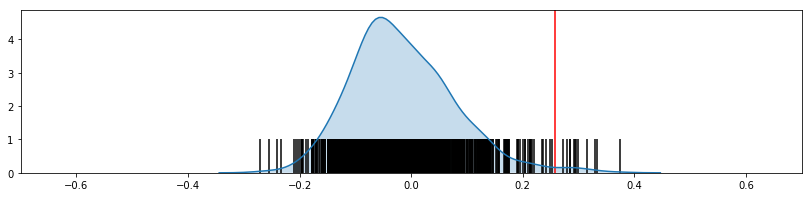

In [166]:
sns.kdeplot(I_entropy_r.sim, shade=True)
plt.vlines(I_entropy_r.sim, 0, 1)
plt.vlines(I_entropy_r.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

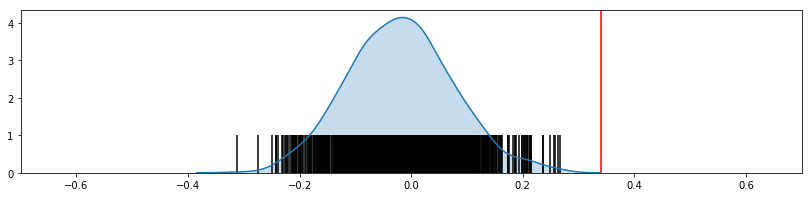

In [167]:
sns.kdeplot(I_rentburden_q.sim, shade=True)
plt.vlines(I_rentburden_q.sim, 0, 1)
plt.vlines(I_rentburden_q.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

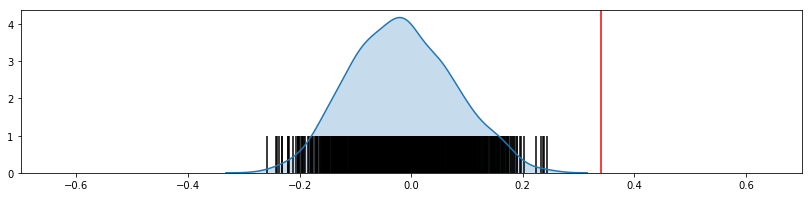

In [168]:
sns.kdeplot(I_rentburden_r.sim, shade=True)
plt.vlines(I_rentburden_r.sim, 0, 1)
plt.vlines(I_rentburden_r.I, 0, 10, 'r')
plt.xlim([-.70, .70])

## 4) Rent burden and entropy index

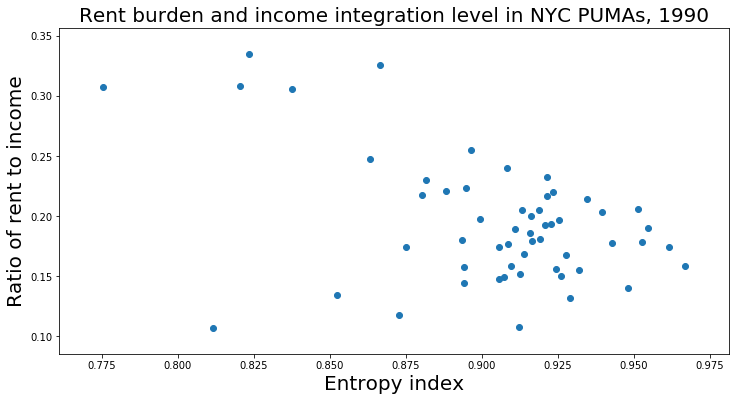

In [169]:
plt.figure(figsize = (12,6))
plt.scatter(df_puma_analysis.entropy_index_9, df_puma_analysis.rent_income_ratio_9)
plt.xlabel('Entropy index',fontsize = 20)
plt.ylabel('Ratio of rent to income',fontsize = 20)
plt.title('Rent burden and income integration level in NYC PUMAs, 1990',fontsize = 20)
plt.show()

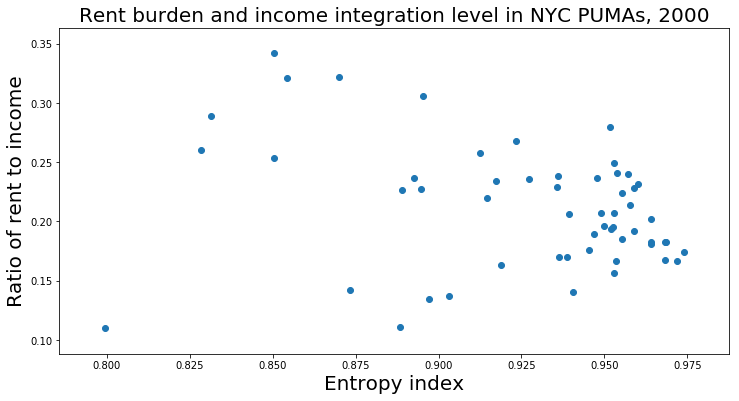

In [170]:
plt.figure(figsize = (12,6))
plt.scatter(df_puma_analysis.entropy_index_0, df_puma_analysis.rent_income_ratio_0)
plt.xlabel('Entropy index',fontsize = 20)
plt.ylabel('Ratio of rent to income',fontsize = 20)
plt.title('Rent burden and income integration level in NYC PUMAs, 2000',fontsize = 20)
plt.show()

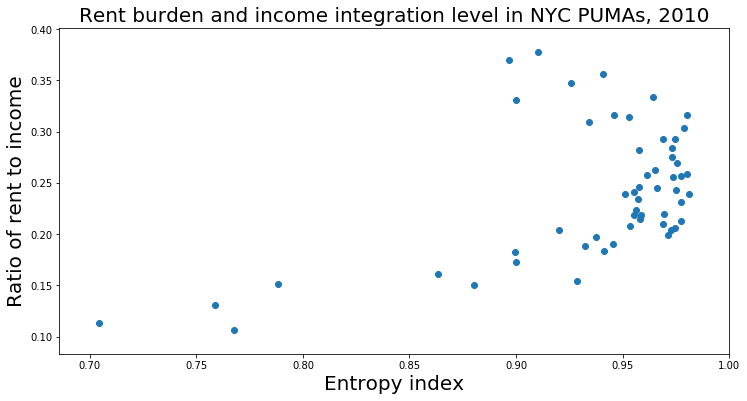

In [171]:
plt.figure(figsize = (12,6))
plt.scatter(df_puma_analysis.entropy_index_1, df_puma_analysis.rent_income_ratio_1)
plt.xlabel('Entropy index',fontsize = 20)
plt.ylabel('Ratio of rent to income',fontsize = 20)
plt.title('Rent burden and income integration level in NYC PUMAs, 2010',fontsize = 20)
plt.show()

In [172]:
df_rentburden_entropy_9 = df_puma_analysis[['PUMA','entropy_index_9', 
                    'rent_income_ratio_9']].rename(columns = {'entropy_index_9':'entropy_index',
                                                    'rent_income_ratio_9':'rent_income_ratio'})
df_rentburden_entropy_9['new_index'] = '9' + df_rentburden_entropy_9.index.astype(str) 

df_rentburden_entropy_0 = df_puma_analysis[['PUMA','entropy_index_0', 
                    'rent_income_ratio_0']].rename(columns = {'entropy_index_0':'entropy_index',
                                                    'rent_income_ratio_0':'rent_income_ratio'})
df_rentburden_entropy_0['new_index'] = '0' + df_rentburden_entropy_9.index.astype(str) 


df_rentburden_entropy_1 = df_puma_analysis[['PUMA','entropy_index_1', 
                    'rent_income_ratio_1']].rename(columns = {'entropy_index_1':'entropy_index',
                                                    'rent_income_ratio_1':'rent_income_ratio'})
df_rentburden_entropy_1['new_index'] = '1' + df_rentburden_entropy_9.index.astype(str) 

In [173]:
df_rentburden_entropy = pd.concat([df_rentburden_entropy_9, 
                        df_rentburden_entropy_0, df_rentburden_entropy_1 ], axis = 0)
df_rentburden_entropy.head()

,PUMA,entropy_index,rent_income_ratio,new_index
0,3701,0.947997,0.140436,90
1,3702,0.914075,0.168343,91
2,3703,0.905603,0.147156,92
3,3704,0.927587,0.167861,93
4,3705,0.820355,0.308408,94


In [174]:
df_rentburden_entropy.shape

(165, 4)

In [175]:
lm_rentburden_entropy = smf.ols('rent_income_ratio ~ entropy_index', df_rentburden_entropy).fit()

In [176]:
lm_rentburden_entropy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_income_ratio   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.586
Date:                Tue, 21 Nov 2017   Prob (F-statistic):              0.110
Time:                        12:57:59   Log-Likelihood:                 235.22
No. Observations:                 165   AIC:                            -466.4
Df Residuals:                     163   BIC:                            -460.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0760      0.087      0.878      0.381      -0.095       0.247
entropy_index     0.1506      0.094      1.608      0.110      -0.034       0.336
==============================================================================
Omnibus:                       14.025   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.648
Skew:                           0.754   Prob(JB):                     0.000400
Kurtosis:                       3.048   Cond. No.                         38.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_00to10 = 0.076 + 0.151 * PUMA_Entropy_Index_00, R-squared = 0.016


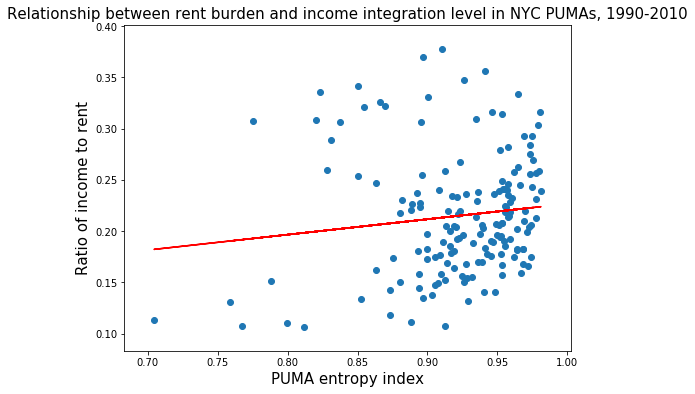

In [177]:
plt.figure(figsize = (8, 6))
plt.scatter(df_rentburden_entropy.entropy_index, df_rentburden_entropy.rent_income_ratio)
plt.plot(df_rentburden_entropy.entropy_index, lm_rentburden_entropy.predict(), c = 'r')
plt.xlabel('PUMA entropy index', fontsize = 15)
plt.ylabel('Ratio of income to rent', fontsize = 15)
plt.title('Relationship between rent burden and income integration level in NYC PUMAs, 1990-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} + {} * PUMA_Entropy_Index_00, R-squared = {}'.format(\
                round(lm_rentburden_entropy.params[0],3), 
                round(lm_rentburden_entropy.params[1],3),
                round(lm_rentburden_entropy.rsquared,3)))

## 5) OLS regression between rent growth and entropy index, on PUMA level

In [178]:
lm1_puma = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_puma_entropy_rent).fit()
lm2_puma = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_puma_entropy_rent).fit()

In [179]:
lm1_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.386
Date:                Tue, 21 Nov 2017   Prob (F-statistic):              0.128
Time:                        12:58:00   Log-Likelihood:                 38.506
No. Observations:                  55   AIC:                            -73.01
Df Residuals:                      53   BIC:                            -69.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.2036      0.395     -0.516      0.608      -0.995       0.588
entropy_index_9     0.6735      0.436      1.545      0.128      -0.201       1.548
==============================================================================
Omnibus:                       17.188   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.967
Skew:                           1.239   Prob(JB):                     2.80e-05
Kurtosis:                       4.734   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
lm2_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1374
Date:                Tue, 21 Nov 2017   Prob (F-statistic):              0.712
Time:                        12:58:00   Log-Likelihood:                 51.236
No. Observations:                  55   AIC:                            -98.47
Df Residuals:                      53   BIC:                            -94.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6435      0.293      2.200      0.032       0.057       1.230
entropy_index_0    -0.1169      0.315     -0.371      0.712      -0.749       0.516
==============================================================================
Omnibus:                       11.209   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.609
Skew:                           0.898   Prob(JB):                      0.00301
Kurtosis:                       4.358   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_00to10 = 0.643 + -0.117 * PUMA_Entropy_Index_00, R-squared = 0.003


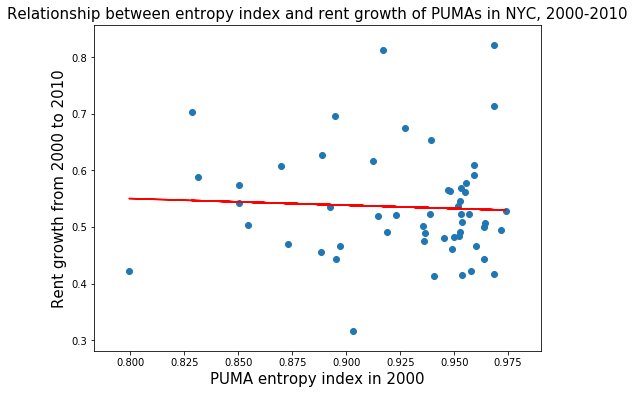

In [181]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy_rent.entropy_index_0, df_puma_entropy_rent.rent_growth_00_10)
plt.plot(df_puma_entropy_rent.entropy_index_0, lm2_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of PUMAs in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} + {} * PUMA_Entropy_Index_00, R-squared = {}'.format(\
                round(lm2_puma.params[0],3), round(lm2_puma.params[1],3),round(lm2_puma.rsquared,3)))

In [182]:
def outlier(x):
    outlier = np.mean(x) + 2 * np.std(x)
    return outlier

In [183]:
df_puma_rich = df_puma_entropy_rent[~((df_puma_median.median_inc_fam_9 < outlier(df_puma_median.median_inc_fam_9))&\
            (df_puma_median.median_inc_fam_0 < outlier(df_puma_median.median_inc_fam_0))&\
            (df_puma_median.median_inc_fam_0 < outlier(df_puma_median.median_inc_fam_0))).values]
df_puma_rich

,PUMA,PUMA_CommunityDistrict,PUMA_neighborhoods,entropy_index_9,entropy_index_0,entropy_index_1,entropy_index_change_90_00,entropy_index_change_00_10,mean_entropy,median_rent_9,median_rent_0,median_rent_1,rent_growth_90_00,rent_growth_00_10
32,3805,Manhattan Community District 8,Upper East Side PUMA,0.811467,0.799350,0.704571,-0.014933,-0.118570,0.771796,860.0,1306.0,1838.0,0.531868,0.421584
33,3806,Manhattan Community District 7,Upper West Side & West Side PUMA,0.912290,0.888430,0.767698,-0.026154,-0.135893,0.856140,615.5,1082.0,1620.0,0.663793,0.455728
35,3808,Manhattan Community District 6,"Murray Hill, Gramercy & Stuyvesant Town PUMA",0.872903,0.873226,0.788169,0.000370,-0.097406,0.844766,773.0,1270.0,1999.0,0.648475,0.470242
37,3810,Manhattan Community District 1 & 2,"Battery Park City, Greenwich Village & Soho PUMA",0.929159,0.903084,0.758828,-0.028063,-0.159737,0.863690,692.0,1198.0,1988.0,0.826174,0.316534


In [184]:
df_puma_norich = df_puma_entropy_rent[((df_puma_median.median_inc_fam_9 < outlier(df_puma_median.median_inc_fam_9))&\
            (df_puma_median.median_inc_fam_0 < outlier(df_puma_median.median_inc_fam_0))&\
            (df_puma_median.median_inc_fam_0 < outlier(df_puma_median.median_inc_fam_0))).values]
df_puma_norich.shape

(51, 14)

In [185]:
lm1_puma_norich = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_puma_norich).fit()
lm2_puma_norich = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_puma_norich).fit()

In [186]:
lm1_puma_norich.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     6.345
Date:                Tue, 21 Nov 2017   Prob (F-statistic):             0.0151
Time:                        12:58:00   Log-Likelihood:                 49.211
No. Observations:                  51   AIC:                            -94.42
Df Residuals:                      49   BIC:                            -90.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.4365      0.326     -1.337      0.187      -1.092       0.219
entropy_index_9     0.9065      0.360      2.519      0.015       0.183       1.630
==============================================================================
Omnibus:                       13.138   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.665
Skew:                           0.950   Prob(JB):                     0.000397
Kurtosis:                       4.940   Cond. No.                         49.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
lm2_puma_norich.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.604
Date:                Tue, 21 Nov 2017   Prob (F-statistic):              0.113
Time:                        12:58:00   Log-Likelihood:                 51.016
No. Observations:                  51   AIC:                            -98.03
Df Residuals:                      49   BIC:                            -94.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0510      0.314      3.346      0.002       0.420       1.682
entropy_index_0    -0.5438      0.337     -1.614      0.113      -1.221       0.133
==============================================================================
Omnibus:                       17.806   Durbin-Watson:                   0.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.308
Skew:                           1.299   Prob(JB):                     1.43e-05
Kurtosis:                       4.936   Cond. No.                         49.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = -0.437 + 0.907 * PUMA_Entropy_Index_90, R-squared = 0.115


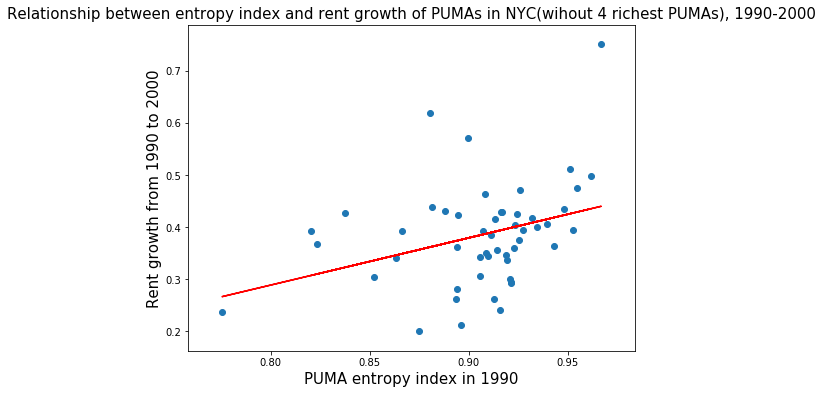

In [188]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_norich.entropy_index_9, df_puma_norich.rent_growth_90_00)
plt.plot(df_puma_norich.entropy_index_9, lm1_puma_norich.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of PUMAs in NYC(wihout 4 richest PUMAs), 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} + {} * PUMA_Entropy_Index_90, R-squared = {}'.format(\
                round(lm1_puma_norich.params[0],3), round(lm1_puma_norich.params[1],3),
                                            round(lm1_puma_norich.rsquared,3)))

In [201]:
HL = [3706,3707,3705,3704,4102,4107,4108,4106,4105,4110,4002,4004, 4104,4017]
HH = [3809, 3802, 3801, 4103, 4104, 4018, 3701, 3702, 3703, 3903, 3901, 3902]

In [202]:
LH = [3803, 3709, 3805, 3808, 3807, 3810, 4109, 4111, 4112, 4008, 4007, 4006, 4013, 4014, 4016]

In [203]:
LL = [3807, 3806, 3804, 3708, 3710, 4101, 4005, 4012, 4011, 4015, 4009, 4113, 4112, 4114]

In [204]:
df_puma_analysis.to_csv('df_all.csv')

In [218]:
HLPUMA = df_puma_analysis[df_puma_analysis.PUMA.isin(HL)]

In [219]:
HHPUMA = df_puma_analysis[df_puma_analysis.PUMA.isin(HH)]

In [220]:
LHPUMA = df_puma_analysis[df_puma_analysis.PUMA.isin(LH)]

In [221]:
LLPUMA = df_puma_analysis[df_puma_analysis.PUMA.isin(LL)]

In [222]:
LHPUMA.columns

Index([u'PUMA', u'PUMA_CommunityDistrict', u'PUMA_neighborhoods',
       u'entropy_index_9', u'entropy_index_0', u'entropy_index_1',
       u'entropy_index_change_90_00', u'entropy_index_change_00_10',
       u'mean_entropy', u'median_inc_fam_9', u'median_rent_9',
       u'median_inc_fam_0', u'median_rent_0', u'median_inc_fam_1',
       u'median_rent_1', u'rent_income_ratio_9', u'rent_income_ratio_0',
       u'rent_income_ratio_1', u'inc_growth_90_00', u'inc_growth_00_10',
       u'rent_growth_90_00', u'rent_growth_00_10'],
      dtype='object')

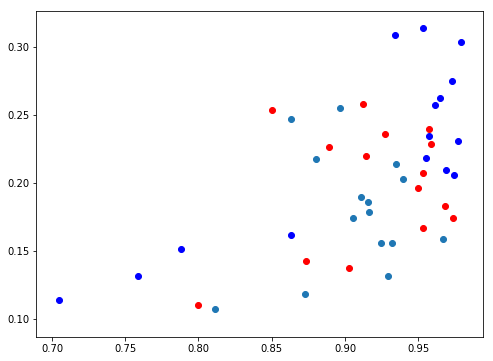

In [223]:
plt.figure(figsize = (8, 6))
plt.scatter(LHPUMA.entropy_index_9, LHPUMA.rent_income_ratio_9)
plt.scatter(LHPUMA.entropy_index_0, LHPUMA.rent_income_ratio_0, color = 'r')
plt.scatter(LHPUMA.entropy_index_1, LHPUMA.rent_income_ratio_1, color = 'b')


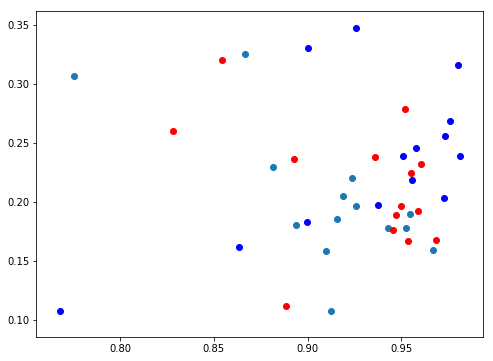

In [224]:
plt.figure(figsize = (8, 6))
plt.scatter(LLPUMA.entropy_index_9, LLPUMA.rent_income_ratio_9)
plt.scatter(LLPUMA.entropy_index_0, LLPUMA.rent_income_ratio_0, color = 'r')
plt.scatter(LLPUMA.entropy_index_1, LLPUMA.rent_income_ratio_1, color = 'b')


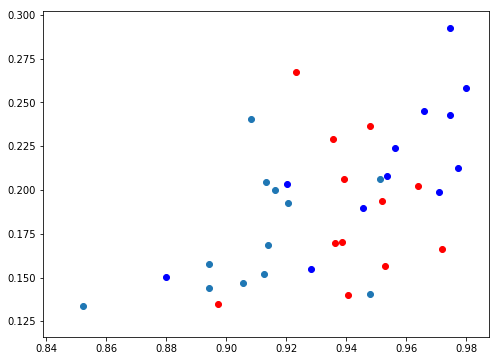

In [225]:
plt.figure(figsize = (8, 6))
plt.scatter(HHPUMA.entropy_index_9, HHPUMA.rent_income_ratio_9)
plt.scatter(HHPUMA.entropy_index_0, HHPUMA.rent_income_ratio_0, color = 'r')
plt.scatter(HHPUMA.entropy_index_1, HHPUMA.rent_income_ratio_1, color = 'b')


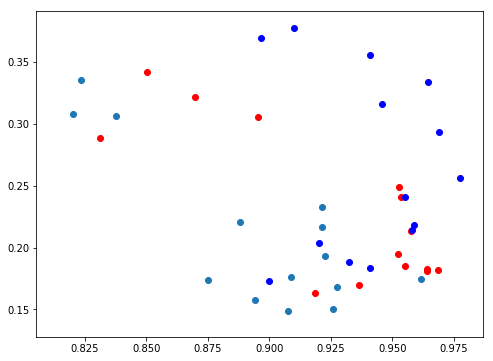

In [226]:
plt.figure(figsize = (8, 6))
plt.scatter(HLPUMA.entropy_index_9, HLPUMA.rent_income_ratio_9)
plt.scatter(HLPUMA.entropy_index_0, HLPUMA.rent_income_ratio_0, color = 'r')
plt.scatter(HLPUMA.entropy_index_1, HLPUMA.rent_income_ratio_1, color = 'b')

In [ ]:
PUMA_shp

In [204]:
df_puma_entropy = PUMA_shp.sort_values(['median_inc_fam_1'])

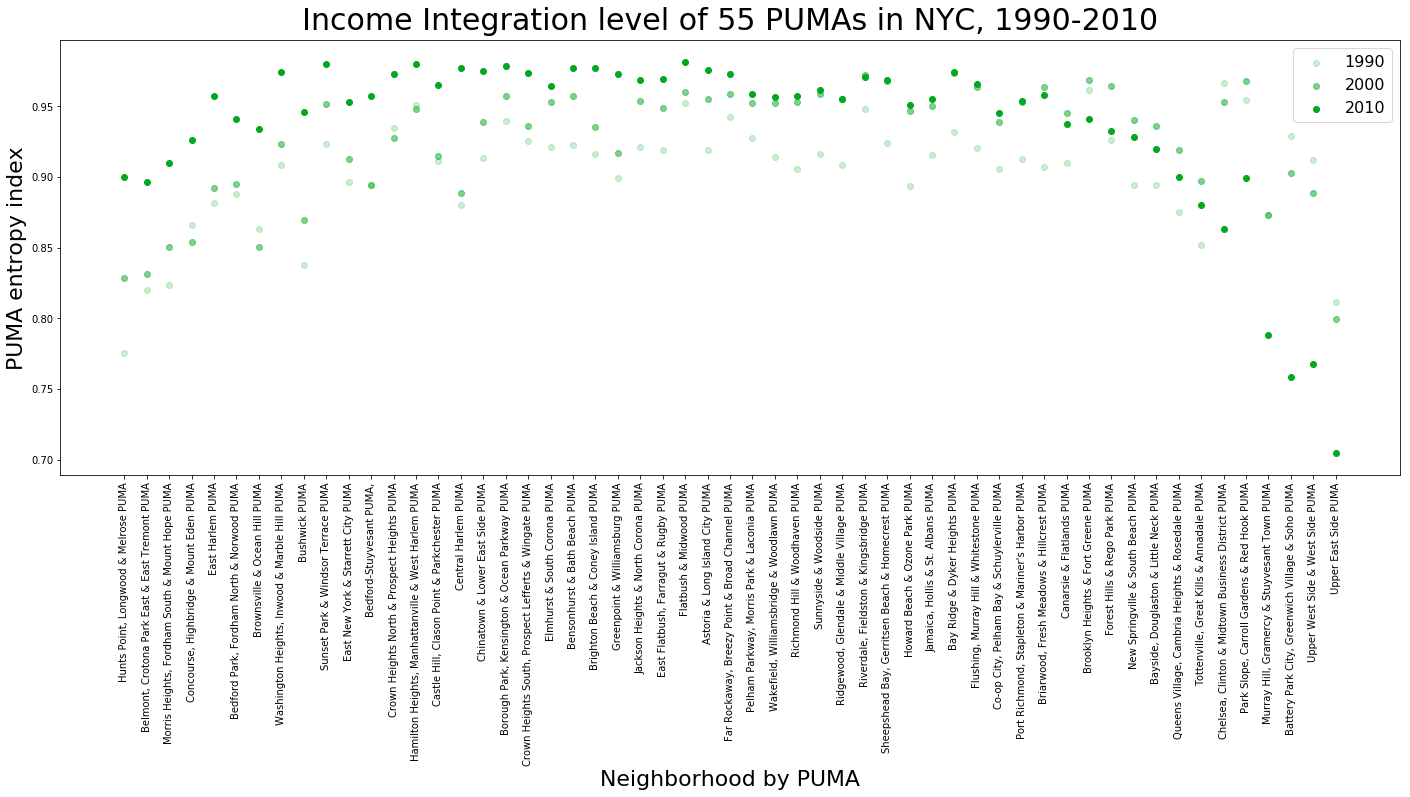

In [205]:
## to see the distribution of entropy index
plt.figure(figsize = (24, 8))
plt.scatter(np.arange(len(df_puma_entropy)),df_puma_entropy.entropy_index_9,
           label = '1990', color='#00A91E', alpha=0.2)
plt.scatter(np.arange(len(df_puma_entropy)),df_puma_entropy.entropy_index_0,
           label = '2000', color='#00A91E', alpha=0.5)
plt.scatter(np.arange(len(df_puma_entropy)),df_puma_entropy.entropy_index_1,
           label = '2010', color='#00A91E')
plt.legend(prop= {'size': 16}, fontsize = 8)

plt.xticks(np.arange(len(df_puma_entropy)), df_puma_entropy.PUMA_neighborhoods, rotation = 90, 
                  fontsize = 10)
#plt.tick_params(axis='x', pad = 2, labelsize = 8, direction = 'in')
plt.ylabel('PUMA entropy index', fontsize = 22)
plt.xlabel('Neighborhood by PUMA', fontsize = 22)
plt.title('Income Integration level of 55 PUMAs in NYC, 1990-2010', fontsize = 30, y=1.01)
plt.show()

In [206]:
df_puma_entropy.columns

Index([                      u'puma',                 u'shape_leng',
                       u'shape_area',                   u'geometry',
                             u'PUMA',     u'PUMA_CommunityDistrict',
               u'PUMA_neighborhoods',            u'entropy_index_9',
                  u'entropy_index_0',            u'entropy_index_1',
       u'entropy_index_change_90_00', u'entropy_index_change_00_10',
                     u'mean_entropy',           u'median_inc_fam_9',
                    u'median_rent_9',           u'median_inc_fam_0',
                    u'median_rent_0',           u'median_inc_fam_1',
                    u'median_rent_1',        u'rent_income_ratio_9',
              u'rent_income_ratio_0',        u'rent_income_ratio_1',
                 u'inc_growth_90_00',           u'inc_growth_00_10',
                u'rent_growth_90_00',          u'rent_growth_00_10',
                   u'entropy_change',         u'rent_income_change',
                       u'inc_chang

In [207]:
len(df_puma_entropy[  df_puma_entropy.median_inc_fam_1 < np.percentile(df_puma_entropy.median_inc_fam_1,25)])

14

In [208]:
len(df_puma_entropy[  df_puma_entropy.median_inc_fam_1 > np.percentile(df_puma_entropy.median_inc_fam_1,50)])

27

In [209]:
len(df_puma_entropy[  df_puma_entropy.median_inc_fam_1 > np.percentile(df_puma_entropy.median_inc_fam_1,75)])

14

In [210]:
df_puma_entropy.median_inc_fam_1.describe()

count        55.000000
mean      64820.800000
std       37552.782138
min       25231.500000
25%       42219.250000
50%       56530.000000
75%       69783.000000
max      205250.000000
Name: median_inc_fam_1, dtype: float64

In [211]:
plt.legend?

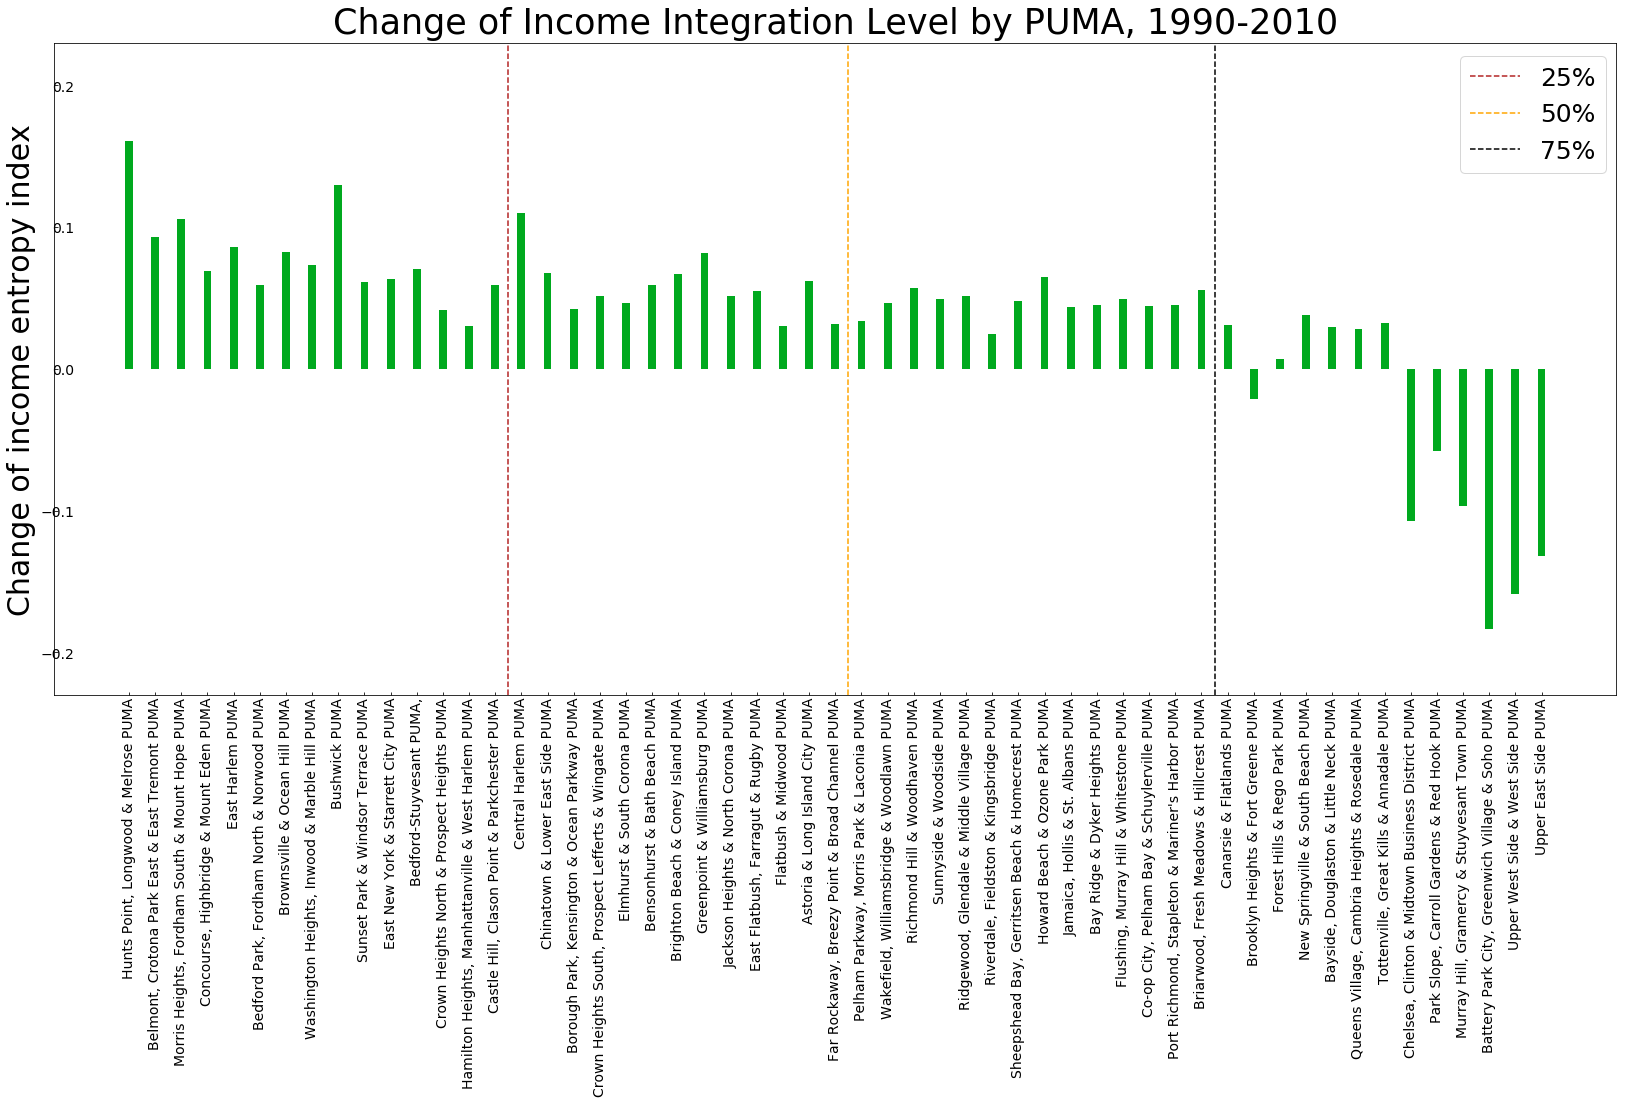

In [212]:
## To see the change of entropy index in the PUMAs
plt.figure(figsize = (28, 12))
plt.bar(np.arange(len(df_puma_entropy)), 
         width = 0.3, color='#00A91E',
        height = df_puma_entropy.entropy_change/100.0)

plt.ylim((-0.23,0.23))
plt.tick_params(axis='y', pad= -20, labelsize=14, direction = 'in', 
                top = True, bottom = True, labeltop= True, labelbottom = True)
plt.xticks(np.arange(len(df_puma_entropy)),df_puma_entropy.PUMA_neighborhoods ,rotation = 90)
plt.tick_params(axis='x', pad=2, labelsize=14, direction = 'in', 
               left = False, right = True, labelleft = False, labelright = True)

# plt.xlabel('neighborhood',fontsize = 21)
plt.ylabel('Change of income entropy index', fontsize = 30)
plt.title('Change of Income Integration Level by PUMA, 1990-2010',fontsize = 35,
         y=1.005)

plt.axvline( x = 14.5, color = 'firebrick', linestyle = '--', label = '25%' )
plt.axvline( x = 27.5, color = 'orange', linestyle = '--', label = '50%' )
plt.axvline( x = 41.5, color = 'black', linestyle = '--', label = '75%' )

# plt.plot(np.linspace(-0.2,0.2,100), 0.75)
# plt.axhline(y = 0.25)
plt.legend(loc = (0.9, 0.8), fontsize = 20, prop= {'size': 25} )
plt.show()

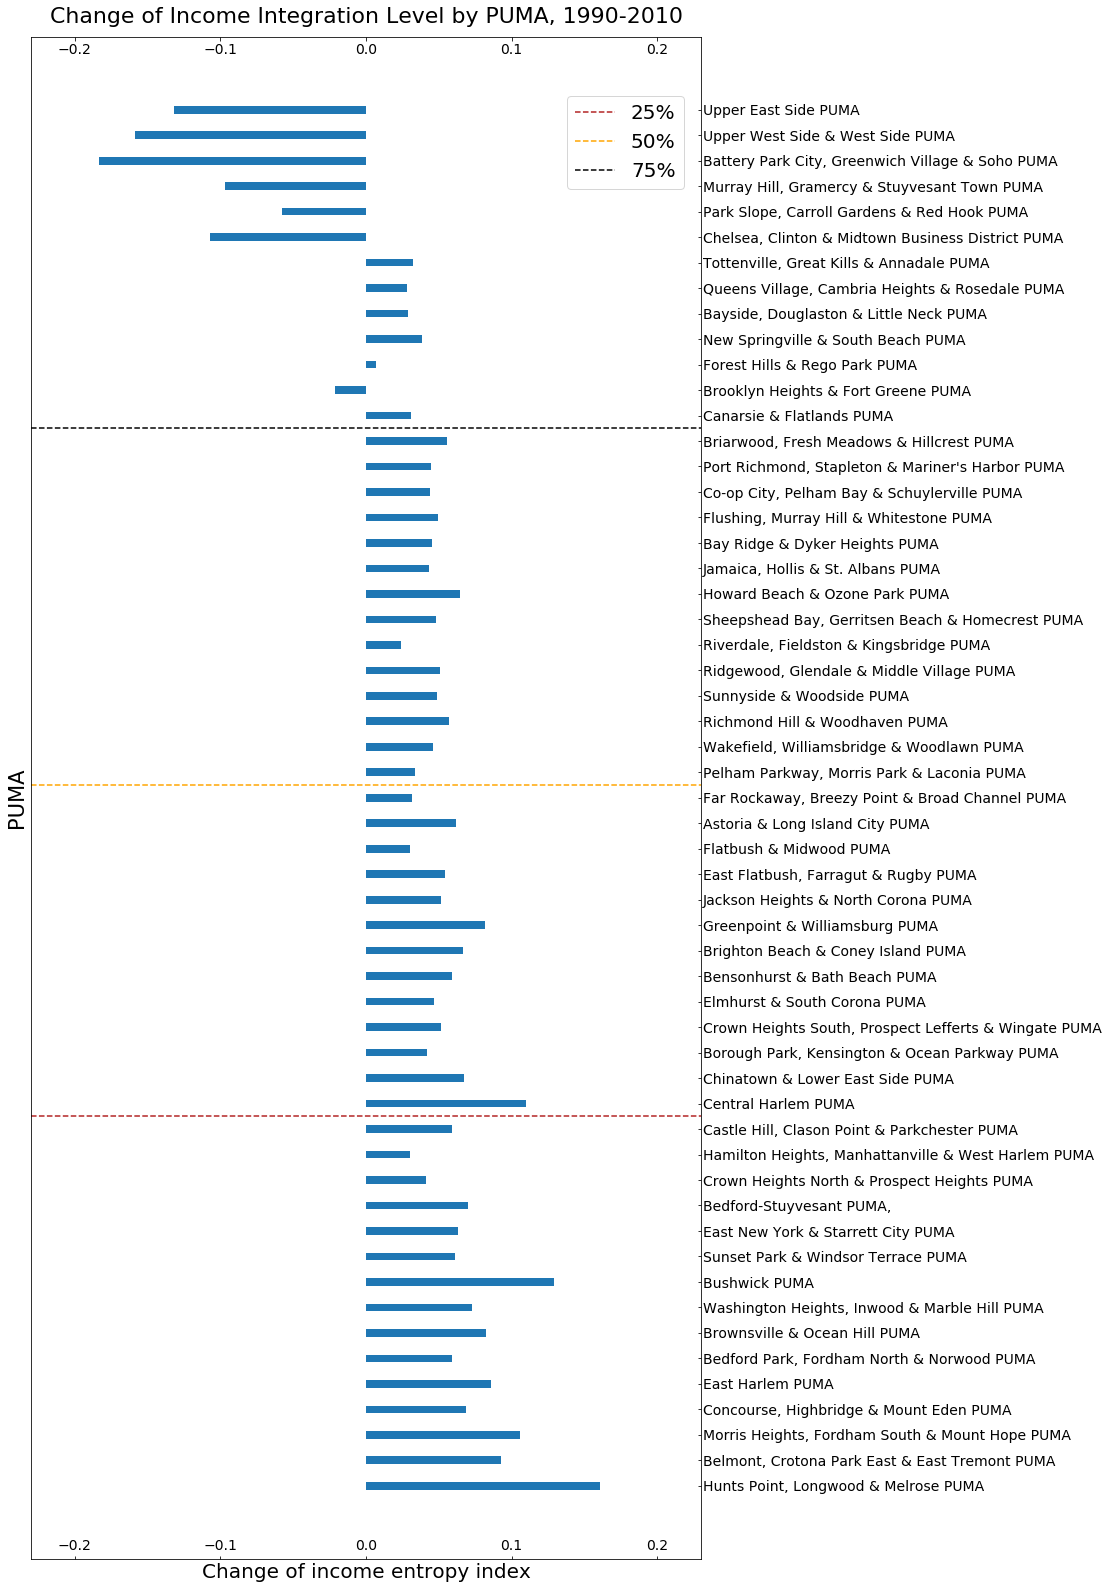

In [213]:
## To see the change of entropy index in the PUMAs
plt.figure(figsize = (12, 28))
plt.barh(np.arange(len(df_puma_entropy)), 
         width = df_puma_entropy.entropy_change/100.0,
        height = 0.3)

plt.xlim((-0.23,0.23))
plt.tick_params(axis='x', pad= -20, labelsize=14, direction = 'in', 
                top = True, bottom = True, labeltop= True, labelbottom = True)
plt.yticks(np.arange(len(df_puma_entropy)),df_puma_entropy.PUMA_neighborhoods )
plt.tick_params(axis='y', pad=2, labelsize=14, direction = 'in', 
               left = False, right = True, labelleft = False, labelright = True)

plt.ylabel('PUMA',fontsize = 21)
plt.xlabel('Change of income entropy index', fontsize = 20, y=1.01)
plt.title('Change of Income Integration Level by PUMA, 1990-2010',fontsize = 22,
         y=1.005)

plt.axhline( y = 14.5, color = 'firebrick', linestyle = '--', label = '25%' )
plt.axhline( y = 27.5, color = 'orange', linestyle = '--', label = '50%' )
plt.axhline( y = 41.5, color = 'black', linestyle = '--', label = '75%' )

# plt.plot(np.linspace(-0.2,0.2,100), 0.75)
# plt.axhline(y = 0.25)
plt.legend(loc = (0.8, 0.9), fontsize = 18, prop= {'size': 20} )
plt.show()

In [214]:
hh = 4001